## Complete Setup & Installation
This cell installs all necessary libraries for the project. It includes bitsandbytes for model quantization, flash-attn for performance optimization (optional but recommended on compatible GPUs), and other core dependencies.

In [ ]:
#!pip install bitsandbytes
# run bit only one time (no need to run everytime)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

### Import Core Libraries
This cell imports all the required Python modules. This includes torch for deep learning, transformers for interacting with the Llama model, googleapiclient for the YouTube API, and various libraries for data handling and visualization.

In [ ]:
# !pip install flash-attn --no-build-isolation

In [ ]:
import torch
import pandas as pd
import re
import time
import os
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from huggingface_hub import login
from google.colab import userdata
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from urllib.parse import urlparse, parse_qs

print("Libraries imported successfully.")

Libraries imported successfully.


### API Authentication
This cell handles authentication. It uses Colab's userdata to securely access your Hugging Face token for model downloads and defines a helper function get_youtube_api_key to retrieve your Google API key for fetching YouTube comments.

In [ ]:
# Cell 3: API Authentication

# --- Hugging Face Login ---
try:
    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
    print("Hugging Face login successful.")
except Exception as e:
    print(f"Hugging Face login failed. Please ensure 'HF_TOKEN' is set in Colab secrets. Error: {e}")

# --- YouTube API Key Helper Function ---
def get_youtube_api_key():
    """Gets the YouTube API key from Colab secrets."""
    try:
        api_key = userdata.get('YOUTUBE_API_KEY')
        if not api_key:
            raise ValueError("YouTube API Key not found. Please add it to Colab secrets.")
        return api_key
    except Exception as e:
        print(f"Error retrieving YouTube API key: {e}")
        return None

Hugging Face login successful.


In [ ]:
# # Cell 4: Model and Pipeline Configuration

# # Define the model ID and check for GPU availability
# MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

# # Configure 4-bit quantization to save memory
# quantization_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16,
#     bnb_4bit_use_double_quant=True,  # Additional optimization for 3.2B model
# )

# # Load tokenizer and model
# print(f"Loading model: {MODEL_ID}...")

# tokenizer = AutoTokenizer.from_pretrained(
#     MODEL_ID,
#     padding_side="left",  # Better for batch processing
#     trust_remote_code=True
# )

# # Set pad token if not present
# if tokenizer.pad_token is None:
#     tokenizer.pad_token = tokenizer.eos_token


### Model and Pipeline Configuration
This cell loads the meta-llama/Llama-3.2-1B-Instruct model. It applies 4-bit quantization using BitsAndBytesConfig to reduce memory usage, making it suitable for a T4 GPU. It also checks for and enables Flash Attention 2 for faster inference if available. Finally, it creates an optimized text-generation pipeline.

In [ ]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# Cell 4: Model and Pipeline Configuration

# Define the model ID and check for GPU availability
MODEL_ID = "meta-llama/Llama-3.2-1B-Instruct" # try 1B, 3B, etc...
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Configure 4-bit quantization to save memory
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,  # Additional optimization for 3.2B model
)

# Load tokenizer and model
print(f"Loading model: {MODEL_ID}...")

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    padding_side="left",  # Better for batch processing
    trust_remote_code=True
)

# Set pad token if not present
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Check if flash attention is available
try:
    import flash_attn
    flash_attn_available = True
    print("Flash Attention 2 detected and will be used for optimization.")
except ImportError:
    flash_attn_available = False
    print("Flash Attention 2 not available, using standard attention.")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True,  # Optimize memory usage
    attn_implementation="flash_attention_2" if (torch.cuda.is_available() and flash_attn_available) else None,
)

# Create a text generation pipeline with optimized settings for 3.2B model
text_generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    return_full_text=False,  # Only return generated text, not input
    batch_size=1,  # Conservative batch size for 3B model
)

print("Llama 3.2 3B Instruct model and pipeline are ready.")
print(f"Model size: 3.2B parameters")
print(f"Memory usage optimized with 4-bit quantization")

# Optional: Display model memory usage
if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

Using device: cuda
Loading model: meta-llama/Llama-3.2-1B-Instruct...


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Flash Attention 2 not available, using standard attention.


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Device set to use cuda:0


Llama 3.2 3B Instruct model and pipeline are ready.
Model size: 3.2B parameters
Memory usage optimized with 4-bit quantization
GPU memory allocated: 0.96 GB
GPU memory cached: 1.43 GB


### Advanced Sentiment Analysis Logic
This cell defines the core sentiment analysis functions. It includes a highly detailed get_telugu_sentiment function with a comprehensive system prompt that instructs the model on Telugu linguistics, cultural context, and code-mixing. It is supported by helper functions for robustly parsing the model's output and a sophisticated keyword-based fallback system (analyze_text_fallback_enhanced) for cases where the AI's response is unclear.

In [ ]:
def get_telugu_sentiment(text_input, domain="general"):
    """
    Classifies sentiment using Llama 3 with an enhanced system prompt for Telugu text.
    Returns 'Positive', 'Negative', or 'Neutral'.

    Args:
        text_input (str): Text to analyze
        domain (str): Context domain - 'movie', 'product', 'social', 'news', or 'general'
    """
    if not isinstance(text_input, str) or not text_input.strip():
        return "Neutral"

    # Domain-specific context
    domain_contexts = {
        "movie": "movie reviews, film critiques, entertainment content",
        "product": "product reviews, e-commerce feedback, shopping experiences",
        "social": "social media posts, personal opinions, casual conversations",
        "news": "news articles, current events, political discussions",
        "general": "general text content"
    }

    domain_context = domain_contexts.get(domain, "general text content")

    system_prompt = f"""You are an expert sentiment analysis specialist with deep expertise in Telugu language, culture, and linguistics. Your task is to analyze sentiment in Telugu and Telugu-English code-mixed text from {domain_context}.

CRITICAL INSTRUCTIONS:
1. You MUST respond with EXACTLY ONE WORD: "Positive", "Negative", or "Neutral"
2. Do NOT include any explanation, reasoning, or additional text
3. Focus on the OVERALL emotional tone, not individual words

TELUGU LANGUAGE EXPERTISE:
- Understand Telugu grammar, syntax, and cultural expressions
- Recognize regional variations and dialects
- Interpret emotional intensity through Telugu linguistic patterns
- Handle honorifics and respect levels that affect sentiment

CODE-MIXING ANALYSIS:
- Telugu-English code-mixing is common - analyze the complete meaning
- English words may carry different emotional weight in Telugu context
- Consider cultural code-switching patterns

SENTIMENT CLASSIFICATION RULES:

POSITIVE indicators:
- Joy, satisfaction, approval, love, excitement, gratitude
- Telugu: బాగుంది, చాలా బాగుంది, అద్భుతం, సంతోషం, ఆనందం, మంచిది, గొప్ప, సూపర్, excellent
- Praise words: అమాజింగ్, వండర్‌ఫుల్, లవ్ చేస్తున్నా, ఇష్టం అయింది
- Achievement expressions: గర్వంగా ఉంది, విజయం, సఫలం

NEGATIVE indicators:
- Anger, sadness, disappointment, frustration, disgust, fear
- Telugu: చెత్త, బాగాలేదు, దురభిప్రాయం, కోపం, బాధ, అసహ్యం, వ్యర్థం, దుఃఖం
- Criticism: waste, boring, చెడ్డది, నిరాశ చెందించింది, time waste
- Strong negatives: worst, terrible, awful, horrible

NEUTRAL indicators:
- Factual statements without emotional charge
- Balanced opinions with both positive and negative aspects
- Informational content, questions, or unclear sentiment
- Mixed emotions that cancel each other out

CULTURAL CONTEXT AWARENESS:
- Telugu speakers often use understatement - "బాగానే ఉంది" might be quite positive
- Respect and politeness markers don't change core sentiment
- Family/relationship contexts may have different emotional expressions
- Regional slang and colloquialisms carry specific emotional weights

ADVANCED ANALYSIS:
- Detect sarcasm through context and cultural patterns
- Identify implicit emotions through cultural references
- Consider intensity levels within each sentiment category
- Handle negations properly in both languages

EXAMPLES:
"మూవీ చాలా బాగుంది, recommend చేస్తున్నా" → Positive
"waste of time అయింది, boring ga ఉంది" → Negative
"average movie, కొన్ని scenes బాగున్నాయి" → Neutral

Remember: Respond with ONLY "Positive", "Negative", or "Neutral" - nothing else."""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Text to analyze: \"{text_input}\""}
    ]

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    try:
        outputs = text_generator(
            messages,
            max_new_tokens=10,  # Increased slightly for better parsing
            eos_token_id=terminators,
            do_sample=False,
            temperature=0.1,  # Very low temperature for consistency
            pad_token_id=tokenizer.eos_token_id,
        )

        # Enhanced response parsing
        generated_text = outputs[0]['generated_text']

        if isinstance(generated_text, list):
            response_part = generated_text[-1]['content']
        elif isinstance(generated_text, str):
            user_prompt_end = f"Text to analyze: \"{text_input}\""
            if user_prompt_end in generated_text:
                response_part = generated_text.split(user_prompt_end)[-1].strip()
            else:
                response_part = generated_text
        else:
            response_part = ""

        # Robust sentiment extraction
        sentiment = extract_sentiment_from_response(response_part)

        if sentiment:
            return sentiment
        else:
            # Enhanced fallback with domain awareness
            return analyze_text_fallback_enhanced(text_input, domain)

    except Exception as e:
        print(f"Error during sentiment analysis: {e}")
        return analyze_text_fallback_enhanced(text_input, domain)


def extract_sentiment_from_response(response_text):
    """Enhanced sentiment extraction from LLM response."""
    if not response_text:
        return None

    # Clean the response
    import re
    clean_text = re.sub(r'[^\w\s]', ' ', response_text.lower()).strip()

    # Look for exact matches with word boundaries
    if re.search(r'\bpositive\b', clean_text):
        return "Positive"
    elif re.search(r'\bnegative\b', clean_text):
        return "Negative"
    elif re.search(r'\bneutral\b', clean_text):
        return "Neutral"

    # Fallback: check if response starts with sentiment word
    first_word = clean_text.split()[0] if clean_text.split() else ""
    if first_word in ['positive', 'negative', 'neutral']:
        return first_word.capitalize()

    return None


def analyze_text_fallback_enhanced(text_input, domain="general"):
    """Enhanced fallback sentiment analysis with domain awareness and improved Telugu support."""
    text_lower = text_input.lower()

    # Comprehensive keyword lists
    positive_keywords = [
        # English positive
        'good', 'great', 'excellent', 'amazing', 'wonderful', 'super', 'awesome', 'love',
        'fantastic', 'brilliant', 'perfect', 'best', 'outstanding', 'impressive', 'beautiful',
        'nice', 'cool', 'sweet', 'adorable', 'magnificent', 'superb', 'marvelous',

        # Telugu positive
        'బాగుంది', 'చాలా బాగుంది', 'అద్భుతం', 'సంతోషం', 'ఆనందం', 'మంచిది', 'గొప్ప',
        'అమోఘం', 'అమాజింగ్', 'ఇష్టం', 'లవ్', 'సూపర్', 'ఎక్సలెంట్', 'బెస్ట్',
        'అందంగా', 'అందమైన', 'అద్భుతమైన', 'గర్వంగా', 'సంతృప్తి', 'విజయం',

        # Domain-specific positive
        'recommend', 'worth', 'value', 'quality', 'satisfied', 'happy', 'enjoyed'
    ]

    negative_keywords = [
        # English negative
        'bad', 'terrible', 'awful', 'horrible', 'waste', 'disappointing', 'hate', 'worst',
        'useless', 'boring', 'stupid', 'annoying', 'frustrating', 'pathetic', 'disgusting',
        'ugly', 'cheap', 'poor', 'failure', 'disaster', 'nightmare', 'trash',

        # Telugu negative
        'చెత్త', 'బాగాలేదు', 'దురభిప్రాయం', 'కోపం', 'బాధ', 'అసహ్యం', 'వ్యర్థం',
        'దుఃఖం', 'చెడ్డది', 'బోరింగ్', 'వేస్ట్', 'నిరాశ', 'అసంతృప్తి', 'ఇష్టంలేదు',
        'హేట్', 'టెర్రిబుల్', 'రాబట్టలేదు', 'ఫెయిల్',

        # Domain-specific negative
        'regret', 'disappointed', 'overpriced', 'defective', 'broken', 'slow', 'expensive'
    ]

    # Neutral indicators
    neutral_keywords = [
        'okay', 'ok', 'average', 'normal', 'fine', 'decent', 'moderate', 'mixed',
        'ఓకే', 'సాధారణం', 'సరే', 'అవరేజ్', 'కొంత', 'కొన్ని'
    ]

    # Enhanced scoring with context
    pos_score = 0
    neg_score = 0
    neutral_score = 0

    # Count keywords with intensity weights
    strong_positive = ['excellent', 'amazing', 'fantastic', 'అద్భుతం', 'అమోఘం', 'గొప్ప']
    strong_negative = ['terrible', 'horrible', 'awful', 'చెత్త', 'అసహ్యం', 'దురభిప్రాయం']

    for word in positive_keywords:
        if word in text_lower:
            weight = 2 if word in strong_positive else 1
            pos_score += weight

    for word in negative_keywords:
        if word in text_lower:
            weight = 2 if word in strong_negative else 1
            neg_score += weight

    for word in neutral_keywords:
        if word in text_lower:
            neutral_score += 1

    # Decision logic with neutral consideration
    total_sentiment_words = pos_score + neg_score + neutral_score

    if total_sentiment_words == 0:
        return "Neutral"

    if neutral_score > 0 and abs(pos_score - neg_score) <= 1:
        return "Neutral"

    if pos_score > neg_score:
        return "Positive"
    elif neg_score > pos_score:
        return "Negative"
    else:
        return "Neutral"

### Unit Testing and Prompt Comparison
This cell tests two different prompting strategies (Simple vs. Enhanced) on a list of predefined Telugu sentences. The output clearly shows that the more complex "Enhanced Prompt" struggles, often defaulting to "Neutral", indicating that simpler, more direct prompts may be more effective for this specific model and task.

In [ ]:
# Cell 6: Test with Predefined Telugu Sentences

telugu_texts = [
    ("ఈ సినిమా చాలా బాగుంది.", "Positive"),
    ("సేవ అస్సలు బాగాలేదు, నేను సంతృప్తి చెందలేదు.", "Negative"),
    ("ఈ వార్త నిన్న ప్రచురించబడింది.", "Neutral"),
    ("అద్భుతమైన రుచి! నేను మళ్ళీ వస్తాను.", "Positive"),
    ("Super movie! Awesome acting, bro.", "Positive"),
    ("Worst experience, waste of time and money.", "Negative"),
    ("సినిమా ఓకే కానీ సాంగ్స్ బాగున్నాయి.", "Mixed/Positive"), # Mixed sentiment
    ("కొన్ని సీన్స్ బాగున్నాయి, కొన్ని బోర్.", "Mixed/Negative"), # Mixed sentiment
    ("Average movie andi, not bad but not great.", "Neutral"),
]

print("--- Starting Sentiment Analysis on Test Sentences ---")
for text, expected in telugu_texts:
    sentiment = get_telugu_sentiment(text)
    print(f"\nText: \"{text}\"")
    print(f"  -> Predicted Sentiment: {sentiment} (Expected: {expected})")
print("\n--- Test Complete ---")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


--- Starting Sentiment Analysis on Test Sentences ---


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Text: "ఈ సినిమా చాలా బాగుంది."
  -> Predicted Sentiment: Neutral (Expected: Positive)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Text: "సేవ అస్సలు బాగాలేదు, నేను సంతృప్తి చెందలేదు."
  -> Predicted Sentiment: Neutral (Expected: Negative)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Text: "ఈ వార్త నిన్న ప్రచురించబడింది."
  -> Predicted Sentiment: Neutral (Expected: Neutral)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Text: "అద్భుతమైన రుచి! నేను మళ్ళీ వస్తాను."
  -> Predicted Sentiment: Neutral (Expected: Positive)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Text: "Super movie! Awesome acting, bro."
  -> Predicted Sentiment: Neutral (Expected: Positive)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Text: "Worst experience, waste of time and money."
  -> Predicted Sentiment: Neutral (Expected: Negative)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Text: "సినిమా ఓకే కానీ సాంగ్స్ బాగున్నాయి."
  -> Predicted Sentiment: Neutral (Expected: Mixed/Positive)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Text: "కొన్ని సీన్స్ బాగున్నాయి, కొన్ని బోర్."
  -> Predicted Sentiment: Neutral (Expected: Mixed/Negative)

Text: "Average movie andi, not bad but not great."
  -> Predicted Sentiment: Neutral (Expected: Neutral)

--- Test Complete ---


### Procedural YouTube Comment Analysis
This cell provides a complete, procedural script to fetch, analyze, and display YouTube comments. It combines the API helper functions, the sentiment analysis logic, and pandas for a final summary. This serves as a non-interactive test of the end-to-end workflow before implementing the final dashboard. The output shows a detailed breakdown of the analysis process.

In [ ]:
# Cell 7: YouTube Comment Analysis

# @title Fetch and Analyze YouTube Comments
YOUTUBE_VIDEO_URL = "https://youtu.be/g9oyP_7feno?si=_tXg1TXDEv_pAvrk" # @param {type:"string"}
MAX_COMMENTS_TO_FETCH = 50 # @param {type:"integer"}

def extract_video_id(url):
    """Extracts the YouTube video ID from various URL formats."""
    parsed_url = urlparse(url)
    if parsed_url.hostname == 'youtu.be':
        return parsed_url.path[1:]
    if parsed_url.hostname in ('www.youtube.com', 'youtube.com'):
        if parsed_url.path == '/watch':
            return parse_qs(parsed_url.query).get('v', [None])[0]
    return None

def fetch_and_analyze_comments(video_url, max_comments):
    api_key = get_youtube_api_key()
    video_id = extract_video_id(video_url)

    if not api_key or not video_id:
        print("Could not proceed without a valid API key and Video ID.")
        return

    youtube = build('youtube', 'v3', developerKey=api_key)
    comments_data = []

    try:
        print(f"Fetching comments for video ID: {video_id}")
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=min(100, max_comments), # API max is 100
            textFormat="plainText"
        )
        response = request.execute()

        for item in response.get("items", []):
            if len(comments_data) >= max_comments:
                break

            comment_snippet = item["snippet"]["topLevelComment"]["snippet"]
            comment_text = comment_snippet["textDisplay"]

            # Clean comment text
            cleaned_comment = re.sub(r'\s+', ' ', comment_text).strip()

            # Analyze sentiment
            sentiment = get_telugu_sentiment(cleaned_comment)

            comments_data.append({
                "Author": comment_snippet["authorDisplayName"],
                "Comment": cleaned_comment,
                "Likes": comment_snippet["likeCount"],
                "Sentiment": sentiment,
            })
            print(f"Analyzed comment {len(comments_data)}/{max_comments} -> {sentiment}")

        # Create and display DataFrame
        df_comments = pd.DataFrame(comments_data)
        pd.set_option('display.max_colwidth', 200)
        pd.set_option('display.max_rows', 100)
        display(df_comments)

    except HttpError as e:
        print(f"\nAn HTTP error occurred: {e.resp.status} {e.content.decode('utf-8')}")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")

# Run the analysis
fetch_and_analyze_comments(YOUTUBE_VIDEO_URL, MAX_COMMENTS_TO_FETCH)

Fetching comments for video ID: g9oyP_7feno


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 1/50 -> Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 2/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 3/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 4/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 5/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 6/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 7/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 8/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 9/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 10/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 11/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 12/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 13/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 14/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 15/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 16/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 17/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 18/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 19/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 20/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 21/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 22/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 23/50 -> Positive


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 24/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 25/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 26/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 27/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 28/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 29/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 30/50 -> Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 31/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 32/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 33/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 34/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 35/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 36/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 37/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 38/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 39/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 40/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 41/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 42/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 43/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 44/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 45/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 46/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 47/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 48/50 -> Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Analyzed comment 49/50 -> Positive
Analyzed comment 50/50 -> Positive


,Author,Comment,Likes,Sentiment
0,@sivasuluru1993,ఈ చిత్రంలో బాగున్నదేంటంట?” అని ఎవరన్నా అడిగితే “ఆఖరి అరగంట” అని చెప్పుకోవాలి.,0,Negative
1,@kashettyavp,😂😂😂😂,1,Neutral
2,@leorao2197,"Don't make negative publicity, kannappa is a good movie.",1,Neutral
3,@NareshYadav-yx1xp,అన్న సినిమా మీరు చెప్పింది 100 కి 200% నిజం సినిమా బాగోలేదు. ముక్యంగా పార్వతి దేవి కి బొట్టు కూడా పెట్టిలేరు అన్న ఇది చాలా పెద్ద మిస్టేక్ సినిమా లో,0,Neutral
4,@SaiKiran-pd6rd,Photo glips thiesara,0,Neutral
5,@sameershaik1298,Action choreography is comedy. Assal bgrade movie fight scenes la undi.,0,Neutral
6,@arsalan-j4n,Stephen devassy telikapodam endhi bro.. He's gem even AR Rehman appreciate him.,0,Neutral
7,@vinayallu772,Bayya. Nuvvu. Sontam ga. Okati. Sort film. Cheyi... Kastam ..😢 telustundi. Movies. Review s. Cheputunnav ..Coments. Chestunnav. 🤬. Google. Lo Search. Chesina. Story line. Telustundi....content..un...,0,Neutral
8,@yaswanth8905,Same feeling Ippude chusa movie but review emo positive ga undhi,0,Neutral
9,@DurgaPrasad-tn3zq,Prabhas name only aaa kane neku nachaledu ee movie lo act cheyyadam,0,Neutral


In [ ]:
# Telugu Sentiment Analysis - Fixed Version
import re # Make sure re is imported

def classify_sentiment_llama3_telugu_enhanced(text_input):
    """
    Classifies sentiment using Llama 3 with a comprehensive system prompt for Telugu text.
    Enhanced for better accuracy with Telugu linguistic patterns.
    Fixed to always return Positive, Negative, or Neutral.
    """
    messages = [
        {
            "role": "system",
            "content": """You are an expert sentiment analysis assistant specializing in Telugu language and Telugu-English code-mixed text.

TASK: Classify the sentiment as exactly one of: Positive, Negative, or Neutral.

TELUGU LANGUAGE GUIDELINES:
- Telugu uses complex sentence structures with subject-object-verb order
- Pay attention to honorific markers (గారు, అయ్యా, అక్కా) which indicate respect but don't change sentiment
- Telugu has many nuanced emotional expressions - consider cultural context
- Code-mixed text (Telugu + English) is common - analyze the overall meaning

SENTIMENT INDICATORS:

POSITIVE indicators in Telugu:
- బాగుంది/బాగున్నాయి (good), చాలా బాగుంది (very good)
- అద్భుతం/అద్భుతమైన (wonderful/amazing), అందం/అందమైన (beautiful)
- సంతోషం/సంతోషకరం (happiness/joyful), ఆనందం (joy)
- పరిపూర్ణ/పూర్తి (perfect/complete), అసాధారణ (extraordinary)
- ఇష్టం/ఇష్టపడ్డాను (like/liked), మంచి/మంచిది (good/nice)
- అభినందనలు (congratulations), సూపర్/అద్భుతం (super/fantastic)

NEGATIVE indicators in Telugu:
- చెత్త/చెత్తగా (bad/badly), భయంకరం (terrible)
- అస్సలు బాగాలేదు (not good at all), దారుణం (horrible)
- బాధ/బాధపడుతున్నాను (sad/feeling sad), కోపం (anger)
- విసుగు/విసుగెత్తుతుంది (boring/getting bored), వేస్ట్ (waste)
- నిరాశ/నిరాశపడ్డాను (disappointment/disappointed)
- సమస్య/ఇబ్బంది (problem/trouble), తప్పు/తప్పిదం (wrong/mistake)

NEUTRAL indicators:
- సాధారణ/మామూలు (normal/ordinary), పర్వాలేదు (it's okay)
- అవును/కాదు (yes/no - context dependent)
- వార్త/సమాచారం (news/information)
- సమయం/తేదీ (time/date related neutral facts)

CRITICAL RULES:
1. Don't be misled by polite language - focus on the core emotion
2. Sarcasm is common in Telugu - detect underlying negative sentiment
3. "చాలా" (very) intensifies the following sentiment
4. Question marks (?) don't automatically make something neutral
5. Consider the entire context, not just individual words
6. Code-mixed expressions: analyze the dominant emotional tone
7. Religious/cultural references need context - they can be positive, negative, or neutral

IMPORTANT: You must respond with EXACTLY ONE WORD: either "Positive", "Negative", or "Neutral". No other text."""
        },
        {
            "role": "user",
            "content": f"Analyze the sentiment of this text: \"{text_input}\""
        }
    ]

    terminators = [
        tokenizer.eos_token_id,
        # tokenizer.convert_tokens_to_ids("<|eot_id|>") # Optional, specific to Llama 3 terminators if needed
    ]

    try:
        outputs = text_generator(
            messages,
            max_new_tokens=3, # Reduced to force single word response
            eos_token_id=terminators,
            do_sample=False,
            temperature=0.01, # Very low temperature for consistency
            top_p=0.5, # Lower for more focused responses
            pad_token_id=tokenizer.eos_token_id
        )

        # --- Enhanced extraction logic ---
        assistant_response = ""
        generated_output = outputs[0]['generated_text']

        if isinstance(generated_output, list):
            if generated_output and generated_output[-1].get("role") == "assistant":
                assistant_response = generated_output[-1].get("content", "").strip()
        elif isinstance(generated_output, str):
            # More robust extraction
            user_prompt_end = f"Analyze the sentiment of this text: \"{text_input}\""
            if user_prompt_end in generated_output:
                response_part = generated_output.split(user_prompt_end)[-1].strip()
                assistant_response = response_part
            else:
                assistant_response = generated_output.strip()

        print(f"DEBUG: Raw assistant response: '{assistant_response}'")

        # Clean the response - remove any extra whitespace and newlines
        assistant_response = re.sub(r'\s+', ' ', assistant_response).strip()

        # Enhanced sentiment extraction with multiple patterns
        sentiment_patterns = [
            r'\b(Positive|Negative|Neutral)\b',
            r'(Positive|Negative|Neutral)',
            r'(?i)\b(positive|negative|neutral)\b',
        ]

        for pattern in sentiment_patterns:
            match = re.search(pattern, assistant_response, re.IGNORECASE)
            if match:
                result = match.group(1).capitalize()
                print(f"DEBUG: Extracted sentiment: {result}")
                return result

        # More aggressive fallback - check for partial matches
        response_lower = assistant_response.lower()

        # Check for positive indicators
        positive_keywords = ['positive', 'pos', 'good', 'happy', 'great', 'excellent', 'wonderful', 'amazing']
        negative_keywords = ['negative', 'neg', 'bad', 'sad', 'terrible', 'awful', 'horrible', 'disappointing']
        neutral_keywords = ['neutral', 'neu', 'okay', 'normal', 'average', 'mixed']

        if any(keyword in response_lower for keyword in positive_keywords):
            print(f"DEBUG: Fallback positive detection")
            return "Positive"
        elif any(keyword in response_lower for keyword in negative_keywords):
            print(f"DEBUG: Fallback negative detection")
            return "Negative"
        elif any(keyword in response_lower for keyword in neutral_keywords):
            print(f"DEBUG: Fallback neutral detection")
            return "Neutral"

        # Last resort: text-based sentiment analysis as backup
        print(f"Warning: Could not parse sentiment from response: '{assistant_response}'. Using text analysis fallback.")
        return analyze_text_fallback(text_input)

    except Exception as e:
        print(f"An error occurred during text generation: {e}")
        return analyze_text_fallback(text_input)

def analyze_text_fallback(text_input):
    """
    Fallback sentiment analysis based on keyword matching for Telugu text.
    Always returns one of: Positive, Negative, or Neutral
    """
    text_lower = text_input.lower()

    # Telugu positive keywords
    positive_telugu = ['బాగుంది', 'బాగున్నాయి', 'అద్భుతం', 'అద్భుతమైన', 'సంతోషం', 'ఆనందం',
                      'మంచి', 'మంచిది', 'సూపర్', 'గ్రేట్', 'ఎక్సలెంట్', 'చాలా బాగుంది']

    # Telugu negative keywords
    negative_telugu = ['చెత్త', 'చెత్తగా', 'భయంకరం', 'బాగాలేదు', 'బాధ', 'కోపం', 'విసుగు',
                       'వేస్ట్', 'నిరాశ', 'దారుణం', 'టెర్రిబుల్']

    # Telugu neutral keywords
    neutral_telugu = ['సాధారణ', 'మామూలు', 'పర్వాలేదు', 'వార్త', 'సమాచారం', 'సమయం', 'ఓకే']

    # Count sentiment indicators
    positive_count = sum(1 for word in positive_telugu if word in text_input) + \
                    sum(1 for word in ['good', 'great', 'excellent', 'amazing', 'wonderful', 'super', 'awesome'] if word in text_lower)

    negative_count = sum(1 for word in negative_telugu if word in text_input) + \
                    sum(1 for word in ['bad', 'terrible', 'awful', 'horrible', 'waste', 'disappointing'] if word in text_lower)

    neutral_count = sum(1 for word in neutral_telugu if word in text_input) + \
                   sum(1 for word in ['okay', 'normal', 'average', 'fine'] if word in text_lower)

    # Determine sentiment based on counts
    if positive_count > negative_count and positive_count > neutral_count:
        return "Positive"
    elif negative_count > positive_count and negative_count > neutral_count:
        return "Negative"
    elif neutral_count > 0:
        return "Neutral"
    elif positive_count > 0:
        return "Positive"
    elif negative_count > 0:
        return "Negative"
    else:
        return "Neutral"  # Default fallback

def classify_sentiment_llama3_telugu_simple(text_input):
    """
    Simple Telugu sentiment classifier for comparison.
    Fixed to always return Positive, Negative, or Neutral.
    """
    messages = [
        {
            "role": "system",
            "content": """You are a Telugu sentiment analysis expert. Classify the sentiment as Positive, Negative, or Neutral.
Consider Telugu language patterns and cultural context.
Respond with EXACTLY ONE WORD: Positive, Negative, or Neutral. No other text."""
        },
        {
            "role": "user",
            "content": f"Classify sentiment: \"{text_input}\""
        }
    ]

    terminators = [tokenizer.eos_token_id]

    try:
        outputs = text_generator(
            messages,
            max_new_tokens=3,
            eos_token_id=terminators,
            do_sample=False,
            temperature=0.01,
            top_p=0.5,
            pad_token_id=tokenizer.eos_token_id
        )

        assistant_response = ""
        generated_output = outputs[0]['generated_text']

        if isinstance(generated_output, list):
            if generated_output and generated_output[-1].get("role") == "assistant":
                assistant_response = generated_output[-1].get("content", "").strip()
        elif isinstance(generated_output, str):
            user_prompt_end = f"Classify sentiment: \"{text_input}\""
            if user_prompt_end in generated_output:
                response_part = generated_output.split(user_prompt_end)[-1].strip()
                assistant_response = response_part
            else:
                assistant_response = generated_output.strip()

        # Clean response
        assistant_response = re.sub(r'\s+', ' ', assistant_response).strip()

        match = re.search(r'\b(Positive|Negative|Neutral)\b', assistant_response, re.IGNORECASE)
        if match:
            return match.group(1).capitalize()
        else:
            # Use fallback analysis
            return analyze_text_fallback(text_input)

    except Exception as e:
        print(f"An error occurred: {e}")
        return analyze_text_fallback(text_input)

# --- Enhanced Test Cases with More Challenging Examples ---
telugu_texts = [
    # Clear Positive
    "ఈ సినిమా చాలా బాగుంది. అద్భుతమైన నటన!", # Very good movie, amazing acting
    "అద్భుతమైన రుచి! నేను మళ్ళీ వస్తాను.", # Amazing taste! I will come again
    "సూపర్ మూవీ! అవ్సమ్ యాక్టింగ్, బ్రో.", # Code-mixed positive

    # Clear Negative
    "సేవ అస్సలు బాగాలేదు, నేను సంతృప్తి చెందలేదు.", # Service not good, not satisfied
    "చాలా చెత్తగా ఉంది, వేస్ట్ ఆఫ్ టైమ్.", # Very bad, waste of time
    "భయంకరమైన అనుభవం, డబ్బు వృధా.", # Terrible experience, money wasted

    # Clear Neutral
    "ఈ వార్త నిన్న ప్రచురించబడింది.", # This news was published yesterday
    "ఈ రోజు వాతావరణం మామూలుగా ఉంది.", # Today's weather is normal
    "సమయం 10 గంటలు.", # Time is 10 o'clock

    # Challenging/Ambiguous Cases
    "పర్వాలేదు, అలాగే ఉంచు.", # It's okay, keep it like that (Neutral/Slightly Positive)
    "అవును, అది నిజమే కానీ...", # Yes, that's true but... (Context dependent)
    "చూద్దామా ఎలా ఉంటుందో.", # Let's see how it will be (Neutral)
    "ఒకే సారి! అంతే!", # Just once! That's it! (Could be positive or negative based on context)

    # Sarcastic/Subtle
    "వాహ్! ఎంత బాగుంది రా ఇది!", # Wow! How good is this! (Could be sarcastic)
    "గొప్ప పని చేశారు మీరు.", # You did a great job (Could be sarcastic)

    # Mixed sentiment
    "సినిమా ఓకే కానీ సాంగ్స్ బాగున్నాయి.", # Movie is okay but songs are good
    "కొన్ని సీన్స్ బాగున్నాయి, కొన్ని బోర్.", # Some scenes good, some boring

    # Code-mixed challenging
    "Average movie andi, not bad but not great.",
    "Super ga start అయ్యింది but ending disappoint అయ్యాను.",

    # Cultural context
    "దేవుడా ఎంత బాధ!", # Oh God, how much pain! (Negative)
    "రామ రామ, ఏం చేసావు!", # Ram Ram, what did you do! (Negative/Shock)
]

print("\n--- Starting Enhanced Telugu Sentiment Analysis ---")
print("Comparing Simple vs Enhanced Prompts")
print("=" * 60)

for i, text in enumerate(telugu_texts):
    print(f"\n{i+1}. Text: \"{text}\"")

    # Test with simple prompt
    simple_sentiment = classify_sentiment_llama3_telugu_simple(text)
    print(f"   Simple Prompt:   {simple_sentiment}")

    # Test with enhanced prompt
    enhanced_sentiment = classify_sentiment_llama3_telugu_enhanced(text)
    print(f"   Enhanced Prompt: {enhanced_sentiment}")

    if simple_sentiment != enhanced_sentiment:
        print(f"   >>> DIFFERENCE DETECTED <<<")

    print("-" * 50)

print("\n--- Analysis Complete ---")
print("Review the differences between simple and enhanced prompts for accuracy assessment.")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- Starting Enhanced Telugu Sentiment Analysis ---
Comparing Simple vs Enhanced Prompts

1. Text: "ఈ సినిమా చాలా బాగుంది. అద్భుతమైన నటన!"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Simple Prompt:   Positive


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

2. Text: "అద్భుతమైన రుచి! నేను మళ్ళీ వస్తాను."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Simple Prompt:   Positive


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

3. Text: "సూపర్ మూవీ! అవ్సమ్ యాక్టింగ్, బ్రో."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

4. Text: "సేవ అస్సలు బాగాలేదు, నేను సంతృప్తి చెందలేదు."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

5. Text: "చాలా చెత్తగా ఉంది, వేస్ట్ ఆఫ్ టైమ్."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

6. Text: "భయంకరమైన అనుభవం, డబ్బు వృధా."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

7. Text: "ఈ వార్త నిన్న ప్రచురించబడింది."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

8. Text: "ఈ రోజు వాతావరణం మామూలుగా ఉంది."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

9. Text: "సమయం 10 గంటలు."
   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

10. Text: "పర్వాలేదు, అలాగే ఉంచు."
   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

11. Text: "అవును, అది నిజమే కానీ..."
   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

12. Text: "చూద్దామా ఎలా ఉంటుందో."
   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

13. Text: "ఒకే సారి! అంతే!"
   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

14. Text: "వాహ్! ఎంత బాగుంది రా ఇది!"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Simple Prompt:   Positive


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

15. Text: "గొప్ప పని చేశారు మీరు."
   Simple Prompt:   Positive


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

16. Text: "సినిమా ఓకే కానీ సాంగ్స్ బాగున్నాయి."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

17. Text: "కొన్ని సీన్స్ బాగున్నాయి, కొన్ని బోర్."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Simple Prompt:   Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
--------------------------------------------------

18. Text: "Average movie andi, not bad but not great."
   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

19. Text: "Super ga start అయ్యింది but ending disappoint అయ్యాను."
   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

20. Text: "దేవుడా ఎంత బాధ!"
   Simple Prompt:   Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

21. Text: "రామ రామ, ఏం చేసావు!"
   Simple Prompt:   Negative
DEBUG: Raw assistant response: 'NEUTRAL'
DEBUG: Extracted sentiment: Neutral
   Enhanced Prompt: Neutral
   >>> DIFFERENCE DETECTED <<<
--------------------------------------------------

--- Analysis Complete ---
Review the differences between simple and enhanced prompts for accuracy assessment.


In [ ]:
# Telugu YouTube Comments Sentiment Analysis - Fixed Version
import pandas as pd
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from urllib.parse import urlparse, parse_qs
import time
import numpy as np
import re

# --- Configuration for YouTube Fetching ---
YOUTUBE_VIDEO_URL = "https://youtu.be/_HJD17g-_l4?si=AL3y3Jw3I5Lm79ng" # @param {type:"string"} # Example Telugu video URL - REPLACE THIS WITH A RELEVANT TELUGU VIDEO!
MAX_COMMENTS_TO_FETCH = 50 # @param {type:"integer"}
COMMENTS_PER_PAGE = 50 # Max allowed by API is 100

# --- Prerequisite Check: Ensure Model and Tokenizer are loaded ---
try:
    # Ensure text_generator pipeline is available
    if 'text_generator' not in globals():
        # This means the cell where the pipeline was created hasn't run
        # We need model and tokenizer to create it.
        if 'model' not in globals() or 'tokenizer' not in globals():
            # If model/tokenizer aren't loaded, try reloading them or raise error
            print("Attempting to reload model and tokenizer for pipeline...")
            from transformers import AutoTokenizer, AutoModelForCausalLM
            import torch # Ensure torch is imported

            # Assuming MODEL_ID is defined in a previous cell
            MODEL_ID = "meta-llama/Llama-3.2-1B-Instruct" # Define if not global

            tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
            # Load model potentially with quantization_config
            try:
                 # Try loading with quantization if config is defined
                 if 'quantization_config' in globals():
                      print("Loading model with quantization config...")
                      model = AutoModelForCausalLM.from_pretrained(
                          MODEL_ID,
                          quantization_config=quantization_config,
                          torch_dtype=torch.bfloat16,
                          device_map="auto",
                          trust_remote_code=True # Often needed
                      )
                 else:
                      print("Loading model without quantization config (quantization_config not found)...")
                      # Fallback without quantization if config is missing
                      model = AutoModelForCausalLM.from_pretrained(
                           MODEL_ID,
                           torch_dtype=torch.bfloat16, # Use bfloat16 if possible
                           device_map="auto",
                           trust_remote_code=True
                      )

            except Exception as model_load_error:
                 raise RuntimeError(f"Failed to load model: {model_load_error}")

            print("Model and tokenizer reloaded.")

        # Create the pipeline (Ensure it uses the loaded model/tokenizer)
        print("Creating text generation pipeline...")
        text_generator = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            torch_dtype=torch.bfloat16, # Match model loading dtype
            device_map="auto" # Ensure pipeline uses the mapped device
        )
        print("Text generation pipeline created.")

    print("Text generation pipeline ready.")

except NameError as e:
     raise NameError(f"ERROR: Essential components (model, tokenizer, or pipeline) not found. Please ensure all setup cells, especially model loading and pipeline creation, were run successfully. Details: {e}")
except Exception as e:
     raise RuntimeError(f"An error occurred setting up the model pipeline: {e}")

# --- Helper Functions ---
def get_youtube_api_key():
    """Gets the YouTube API key from Colab secrets."""
    # Ensure userdata is imported
    from google.colab import userdata
    try:
        api_key = userdata.get('YOUTUBE_API_KEY')
        if not api_key:
            raise ValueError("YouTube API Key not found in Colab secrets. Please add it with the name 'YOUTUBE_API_KEY'.")
        return api_key
    except ImportError:
        raise EnvironmentError("userdata module not found. Are you running this in Google Colab?")
    except Exception as e:
        print(f"Error retrieving API key: {e}")
        return None

def extract_video_id(url):
    """Extracts the YouTube video ID from various URL formats."""
    parsed_url = urlparse(url)
    if parsed_url.hostname == 'youtu.be':
        return parsed_url.path[1:]
    if parsed_url.hostname in ('www.youtube.com', 'youtube.com'):
        if parsed_url.path == '/watch':
            p = parse_qs(parsed_url.query)
            return p.get('v', [None])[0]
        if parsed_url.path.startswith('/embed/'):
            return parsed_url.path.split('/')[2]
        if parsed_url.path.startswith('/v/'):
            return parsed_url.path.split('/')[2]
    print(f"Warning: Could not extract video ID from URL: {url}")
    return None

def analyze_telugu_sentiment_fallback(text):
    """
    Fallback sentiment analysis for Telugu text using keyword matching.
    Specifically tuned for YouTube comments patterns.
    """
    text_lower = text.lower()
    text_original = text  # Keep original for Telugu script

    # Telugu positive keywords (common in YouTube comments)
    positive_telugu = [
        'బాగుంది', 'బాగున్నాయి', 'అద్భుతం', 'అద్భుతమైన', 'సంతోషం', 'ఆనందం',
        'మంచి', 'మంచిది', 'సూపర్', 'గ్రేట్', 'ఎక్సలెంట్', 'చాలా బాగుంది',
        'లవ్', 'లవ్లీ', 'నైస్', 'వండర్ఫుల్', 'అమేజింగ్', 'ఫాంటాస్టిక్',
        'అవ్సమ్', 'కూల్', 'సూపర్బ్', 'ఎక్సలెంట్', 'వావ్', 'బెస్ట్'
    ]

    # Telugu negative keywords (common in YouTube comments)
    negative_telugu = [
        'చెత్త', 'చెత్తగా', 'భయంకరం', 'బాగాలేదు', 'బాధ', 'కోపం', 'విసుగు',
        'వేస్ట్', 'నిరాశ', 'దారుణం', 'టెర్రిబుల్', 'బాడ్', 'బోర్', 'బోరింగ్',
        'డిసాపాయింట్', 'హేట్', 'వర్స్ట్', 'ఉసేలేస్', 'స్టుపిడ్'
    ]

    # Telugu neutral keywords
    neutral_telugu = [
        'సాధారణ', 'మామూలు', 'పర్వాలేదు', 'వార్త', 'సమాచారం', 'సమయం',
        'ఓకే', 'అవ్సరం', 'చెప్పాలి', 'చూద్దాం', 'తెలుసా', 'ఎలా', 'ఎప్పుడు'
    ]

    # English positive keywords (common in Telugu YouTube comments)
    positive_english = [
        'good', 'great', 'excellent', 'amazing', 'wonderful', 'super', 'awesome',
        'love', 'lovely', 'nice', 'fantastic', 'perfect', 'beautiful', 'best',
        'cool', 'superb', 'outstanding', 'brilliant', 'fabulous', 'wow', 'yes'
    ]

    # English negative keywords
    negative_english = [
        'bad', 'terrible', 'awful', 'horrible', 'waste', 'disappointing', 'hate',
        'worst', 'useless', 'stupid', 'boring', 'poor', 'pathetic', 'disaster',
        'disgusting', 'annoying', 'frustrating', 'no', 'never', 'stop'
    ]

    # English neutral keywords
    neutral_english = [
        'okay', 'ok', 'normal', 'average', 'fine', 'maybe', 'perhaps', 'probably',
        'think', 'believe', 'seems', 'appears', 'looks', 'feel', 'when', 'where',
        'what', 'how', 'why', 'time', 'day', 'today', 'tomorrow', 'yesterday'
    ]

    # Count sentiment indicators
    positive_count = 0
    negative_count = 0
    neutral_count = 0

    # Check Telugu words in original text
    for word in positive_telugu:
        if word in text_original:
            positive_count += 2  # Give Telugu words more weight

    for word in negative_telugu:
        if word in text_original:
            negative_count += 2

    for word in neutral_telugu:
        if word in text_original:
            neutral_count += 1

    # Check English words in lowercase text
    for word in positive_english:
        if word in text_lower:
            positive_count += 1

    for word in negative_english:
        if word in text_lower:
            negative_count += 1

    for word in neutral_english:
        if word in text_lower:
            neutral_count += 1

    # Special patterns for YouTube comments
    if '👍' in text or '❤️' in text or '😍' in text or '😊' in text or '🔥' in text:
        positive_count += 2

    if '👎' in text or '😠' in text or '😡' in text or '💩' in text:
        negative_count += 2

    if '❓' in text or '❔' in text or '🤔' in text:
        neutral_count += 1

    # Check for exclamation marks (often positive in YouTube comments)
    exclamation_count = text.count('!')
    if exclamation_count > 0:
        positive_count += min(exclamation_count, 3)  # Cap at 3

    # Check for question marks (often neutral)
    question_count = text.count('?')
    if question_count > 0:
        neutral_count += min(question_count, 2)  # Cap at 2

    # Check for all caps (can be positive or negative)
    if text.isupper() and len(text) > 5:
        # If it contains positive words, it's enthusiastic
        if any(word.upper() in text for word in ['GOOD', 'GREAT', 'SUPER', 'WOW', 'YES']):
            positive_count += 1
        else:
            negative_count += 1  # All caps often indicates anger

    print(f"DEBUG: Text: '{text[:50]}...' | Pos: {positive_count}, Neg: {negative_count}, Neu: {neutral_count}")

    # Determine sentiment based on counts
    if positive_count > negative_count and positive_count > neutral_count:
        return "Positive"
    elif negative_count > positive_count and negative_count > neutral_count:
        return "Negative"
    elif neutral_count > 0 and neutral_count >= positive_count and neutral_count >= negative_count:
        return "Neutral"
    elif positive_count == negative_count and positive_count > 0:
        return "Neutral"  # Mixed sentiment
    elif positive_count > 0:
        return "Positive"
    elif negative_count > 0:
        return "Negative"
    else:
        return "Neutral"  # Default when no clear indicators

def classify_sentiment_llama3_telugu_youtube(text_input):
    """
    Classifies sentiment for Telugu YouTube comments using Llama 3.
    Optimized for YouTube comment patterns and mixed-language content.
    """
    # Clean the input text
    text_cleaned = re.sub(r'\s+', ' ', text_input).strip()

    # If text is too short, use fallback
    if len(text_cleaned) < 3:
        return "Neutral"

    messages = [
        {
            "role": "system",
            "content": """You are an expert at analyzing Telugu YouTube comments for sentiment.

Classify the sentiment as exactly one word: Positive, Negative, or Neutral.

YOUTUBE COMMENT CONTEXT:
- Comments are often short, informal, and use mixed Telugu-English
- Emojis are common: 👍❤️😍😊🔥 = positive, 👎😠😡💩 = negative
- ALL CAPS often shows strong emotion (positive or negative)
- Multiple exclamation marks usually indicate enthusiasm

TELUGU YOUTUBE PATTERNS:
- "బాగుంది" "సూపర్" "అద్భుతం" = Positive
- "చెత్త" "బాగాలేదు" "వేస్ట్" = Negative
- "ఓకే" "సాధారణ" "పర్వాలేదు" = Neutral

ENGLISH MIXED PATTERNS:
- "super", "awesome", "love it", "great" = Positive
- "bad", "boring", "waste", "hate" = Negative
- "ok", "normal", "fine" = Neutral

Respond with ONLY ONE WORD: Positive, Negative, or Neutral."""
        },
        {
            "role": "user",
            "content": f"Sentiment of this YouTube comment: \"{text_cleaned}\""
        }
    ]

    terminators = [tokenizer.eos_token_id]

    try:
        outputs = text_generator(
            messages,
            max_new_tokens=3,
            eos_token_id=terminators,
            do_sample=False,
            temperature=0.01,
            top_p=0.3,  # Very focused
            pad_token_id=tokenizer.eos_token_id
        )

        assistant_response = ""
        generated_output = outputs[0]['generated_text']

        if isinstance(generated_output, list):
            if generated_output and generated_output[-1].get("role") == "assistant":
                assistant_response = generated_output[-1].get("content", "").strip()
        elif isinstance(generated_output, str):
            user_prompt_end = f"Sentiment of this YouTube comment: \"{text_cleaned}\""
            if user_prompt_end in generated_output:
                response_part = generated_output.split(user_prompt_end)[-1].strip()
                assistant_response = response_part
            else:
                assistant_response = generated_output.strip()

        # Clean the response
        assistant_response = re.sub(r'\s+', ' ', assistant_response).strip()

        # Try to extract sentiment
        sentiment_patterns = [
            r'\b(Positive|Negative|Neutral)\b',
            r'(Positive|Negative|Neutral)',
            r'(?i)\b(positive|negative|neutral)\b',
        ]

        for pattern in sentiment_patterns:
            match = re.search(pattern, assistant_response, re.IGNORECASE)
            if match:
                result = match.group(1).capitalize()
                print(f"DEBUG: LLM Response: '{assistant_response}' -> Extracted: {result}")
                return result

        # If no clear sentiment found, use fallback
        print(f"DEBUG: LLM unclear response: '{assistant_response}'. Using fallback.")
        return analyze_telugu_sentiment_fallback(text_cleaned)

    except Exception as e:
        print(f"DEBUG: LLM error: {e}. Using fallback.")
        return analyze_telugu_sentiment_fallback(text_cleaned)

# --- Main Logic for YouTube Comments ---
api_key = get_youtube_api_key()
video_id = extract_video_id(YOUTUBE_VIDEO_URL)
comments_data = []

if api_key and video_id:
    try:
        youtube = build('youtube', 'v3', developerKey=api_key)
        print(f"Fetching comments for video ID: {video_id}")
        next_page_token = None
        comments_fetched = 0

        while comments_fetched < MAX_COMMENTS_TO_FETCH:
            request = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                maxResults=min(COMMENTS_PER_PAGE, MAX_COMMENTS_TO_FETCH - comments_fetched),
                textFormat="plainText",
                pageToken=next_page_token
            )
            response = request.execute()

            for item in response.get("items", []):
                if comments_fetched >= MAX_COMMENTS_TO_FETCH: break
                comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
                comment_cleaned = re.sub(r'\s+', ' ', comment).strip()
                if not comment_cleaned:
                    continue

                author = item["snippet"]["topLevelComment"]["snippet"]["authorDisplayName"]
                published_at = item["snippet"]["topLevelComment"]["snippet"]["publishedAt"]
                like_count = item["snippet"]["topLevelComment"]["snippet"]["likeCount"]

                print(f"\nAnalyzing comment {comments_fetched + 1}/{MAX_COMMENTS_TO_FETCH}:")
                print(f"Author: {author}")
                print(f"Comment: \"{comment_cleaned[:150]}{'...' if len(comment_cleaned) > 150 else ''}\"")

                # Use the improved YouTube-specific sentiment function
                sentiment = classify_sentiment_llama3_telugu_youtube(comment_cleaned)
                print(f"Predicted Sentiment: {sentiment}")

                comments_data.append({
                    "Author": author,
                    "Published At": published_at,
                    "Comment": comment, # Store original comment
                    "Likes": like_count,
                    "Predicted Sentiment": sentiment
                })
                comments_fetched += 1

            next_page_token = response.get("nextPageToken")
            if not next_page_token or comments_fetched >= MAX_COMMENTS_TO_FETCH: break
            time.sleep(0.5)

        print(f"\nFetched and analyzed {comments_data} comments.")

    except HttpError as e:
        print(f"\nAn HTTP error {e.resp.status} occurred:")
        error_content = e.content.decode('utf-8')
        print(error_content)
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")

else:
    print("\nSkipping YouTube comment fetching: API key or video ID is missing/invalid.")

# --- Display Results ---
if comments_data:
    df_comments = pd.DataFrame(comments_data)
    print("\n--- YouTube Comment Sentiment Analysis Results ---")

    # Display sentiment distribution
    sentiment_counts = df_comments['Predicted Sentiment'].value_counts()
    print(f"\nSentiment Distribution:")
    for sentiment, count in sentiment_counts.items():
        percentage = (count / len(df_comments)) * 100
        print(f"{sentiment}: {count} ({percentage:.1f}%)")

    # Display the dataframe
    pd.set_option('display.max_colwidth', 200)
    pd.set_option('display.max_rows', 100)
    display(df_comments)

    # Show some example comments for each sentiment
    print("\n--- Example Comments by Sentiment ---")
    for sentiment in ['Positive', 'Negative', 'Neutral']:
        sentiment_examples = df_comments[df_comments['Predicted Sentiment'] == sentiment]
        if not sentiment_examples.empty:
            print(f"\n{sentiment} Examples:")
            for i, row in sentiment_examples.head(3).iterrows():
                print(f"  - \"{row['Comment'][:100]}{'...' if len(row['Comment']) > 100 else ''}\"")
        else:
            print(f"\n{sentiment} Examples: None found")

else:
    print("\nNo comments were fetched or analyzed.")

Text generation pipeline ready.
Fetching comments for video ID: _HJD17g-_l4


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Analyzing comment 1/50:
Author: @LOKIZ-n3c
Comment: "Bro is grandparents favourite child"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 2/50:
Author: @ravisadasivuni6865
Comment: "Varada vadini apa mani cheppu😂😂"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 3/50:
Author: @zero99rj
Comment: "I observed clubbing in Pranay's fingers. Get yourself checked once you might have a serious heart disorder. Take care of yourself bro. Wishing you guy..."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 4/50:
Author: @SunilKohir-o4g
Comment: "Ayana thinte mikem guddalo nopi beeeee"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 5/50:
Author: @addepallihemanth592
Comment: "Bro ni okkaroju fasting cheyipinchi Annadanam chepiste 10members ki full days meals set😢"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 6/50:
Author: @monica_glory
Comment: "Niku assalu vandatame rani wife vastadi bro 😅😂"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 7/50:
Author: @Arprio2022
Comment: "Bro 21:29 doesn't need detox drink he needs domax😂❤"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 8/50:
Author: @MDEEVANKumar99
Comment: "😂😂😂😂"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 9/50:
Author: @deviganeshpunna5250
Comment: "వాడిది కడుపా చెరువు అన్న"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 10/50:
Author: @SanthoshBirlangi
Comment: "😂😂😂😂😂😂😂"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 11/50:
Author: @chidambareswar
Comment: "Bro evadi thindi vadidhi bro"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 12/50:
Author: @mr__ashish__8776
Comment: "Women soulfull vachhindhi thana meedha video chey"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 13/50:
Author: @SandeepPrince-h6g
Comment: "Areyyyy... Johny Sins kuda koncham Gap isthadu Ra...."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 14/50:
Author: @JayalaxmiPulipati
Comment: "Waste fellow pranay why are you doing this video 📷📷📷"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 15/50:
Author: @mandasaikumar2062
Comment: "Man of the match of the series of the tournament 😂😂"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 16/50:
Author: @sai00x
Comment: "Erripukulu antha oka Eyy chota Eyy cheraru elaa 😂❤"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 17/50:
Author: @TiruvayapatiSuresh
Comment: "Anna vadu yakkada unnatado chappava dhaba vakkati patukuntta please"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 18/50:
Author: @adityakoppera
Comment: "that annaaaaww transition is awsome"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 19/50:
Author: @gireeshmachilakala-b6e
Comment: "Bro intha tinndaniki money ella saripothundi bro..."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 20/50:
Author: @Sairam004
Comment: "Watching after Soulful Vlogs eating 40 Bajjis live"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 21/50:
Author: @akhilkumar.k5650
Comment: "Antha daily tinadhaniki money yekkadivi bro athaniki"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 22/50:
Author: @rajaravindraberi980
Comment: "❤❤❤❤😂😂😂😂😂😂😂"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 23/50:
Author: @arisemeghana2289
Comment: "U are having clubbing in ur fingers....could be due to smoking or lung or heart problem....plz get a physician consultation for evaluation"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 24/50:
Author: @tejateja4605
Comment: "Anna navvi navvi sacchipoya anna😂😂"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 25/50:
Author: @GouthuMani
Comment: "Sighu ledha miku puku😢😢😢"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 26/50:
Author: @ravinandan6648
Comment: "Anna vadiki yeakkadaninchi dobbulu vasta vundhi bro"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 27/50:
Author: @kiranraj8143
Comment: "Vastuadu dengii tintadu saripolesu antadu 😂 kadupa cheruva bayaaaaa 😅"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 28/50:
Author: @yugandharreddy5494
Comment: "అన్న ఈడు డబల్ ఎగ్ దోశ గాడు అన్న 😂😂"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 29/50:
Author: @ramayya_janasena
Comment: "Depression edusthuna bhayya me video chusaka a bhadha antha poyindhi 😭🩷🫂... Tqsm brooo 😭🩷🫂"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 30/50:
Author: @LeoEvent
Comment: "Chillar nayala andhra kada g Balupu baga periginattundi pani pata leka ntra edi mek avasarama..."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 31/50:
Author: @muktaniharika1302
Comment: "Anna monna live lo 40 samosalu tinnadu 😌"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 32/50:
Author: @musicrocks1991
Comment: "Bhayya meeru sappattu raman videos chusi vaati mida kooda cheyyandi"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 33/50:
Author: @ravalibilla5096
Comment: "Navvi navvi sachipothe avaru responsibility bro..😂😂😂 Kumba karnudu aiena 6 months thini 6 months padukuntadu nuventiii brooo"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 34/50:
Author: @CPNagur
Comment: "This video never gets old ..if I am getting stressed coming to watch this video brooo"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 35/50:
Author: @alienforcegaming6923
Comment: "https://youtu.be/UQEKer2-vnc?si=0xTjf0oMG9_tyvJw"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 36/50:
Author: @CRIC_FREAK140_07
Comment: "Fasting concept untey Just morning ki green leafy veggie salad,adhi saripokapothe vegetable salad adhi saripokapothe vegetable juices 2 or 3 Then for ..."


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 37/50:
Author: @Asiankowshikcinemas
Comment: "Yudham kuda aaru thavata apestaru kadara nuvu inka tintane nuvu 😭😭😂😂🤣🤣🤣🤣🤣🤣🤣🤣🤣"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 38/50:
Author: @badrinath4928
Comment: "18:47 bro aapand bro😂😂😂😂🤣"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 39/50:
Author: @pspkfan4067
Comment: "Saripoda pratiroju"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 40/50:
Author: @dhanunjay1907
Comment: "Rendu nelala tarvatha choosina... Malla aalne kadupulo tipputhundi bro 🙂"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 41/50:
Author: @karreddullagowtham
Comment: "Meku anduku brother taneke meru hamana money hetanara tana money tanu istam meku haduguku"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 42/50:
Author: @PrasannaSimhadri-j8r
Comment: "Anna the paradise glimpse reaction cheyyandi plzz"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 43/50:
Author: @sakettimmaraju
Comment: "Mayfel is a emotion"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 44/50:
Author: @amgotha.ganesh363
Comment: "Anna nenu nela motham thinedi okaroju thinndu bro"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 45/50:
Author: @SunnySunny-x5r6g
Comment: "Action⚔️ overaction"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Analyzing comment 46/50:
Author: @VishnuVardhanReddy-q1t3x
Comment: "Some places it looked like fake laughter"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 47/50:
Author: @mdmasood6957
Comment: "Same bro laga inka vikashu same video but that man drink vi video chestadhu"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 48/50:
Author: @sgfuegoo-1xz
Comment: "Meeku anduku ra kathal vadu money vadu istam pilla puvvala"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 49/50:
Author: @akkyamdevisreemunirathnam5481
Comment: "Bro thinadam choosi meeke respect perigindhi video first lo arey , vaadu ani pilichina mee nota " anna " ani pilipinchukunndu 😂 respect 🫡"


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative
Predicted Sentiment: Negative

Analyzing comment 50/50:
Author: @rapomania1235
Comment: "Alaa thintaadu bro .......digestive system kuda vadiki sanmanam chesthadhi bro"
DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral
Predicted Sentiment: Neutral

Fetched and analyzed [{'Author': '@LOKIZ-n3c', 'Published At': '2025-06-28T16:20:06Z', 'Comment': 'Bro is grandparents favourite child', 'Likes': 0, 'Predicted Sentiment': 'Negative'}, {'Author': '@ravisadasivuni6865', 'Published At': '2025-06-28T09:23:27Z', 'Comment': 'Varada vadini apa mani cheppu😂😂', 'Likes': 0, 'Predicted Sentiment': 'Neutral'}, {'Author': '@zero99rj', 'Published At': '2025-06-27T21:05:05Z', 'Comment': "I observed clubbing in Pranay's fingers. Get yourself checked once you might have a serious heart disorder. Take care of yourself bro. Wishing you guys all the best👍🏻 @pranay verma", 'Likes': 0, 'Predicted Sentiment': 'Neutral'}, {'Author': '@SunilKohir-o4g', 'Publ

,Author,Published At,Comment,Likes,Predicted Sentiment
0,@LOKIZ-n3c,2025-06-28T16:20:06Z,Bro is grandparents favourite child,0,Negative
1,@ravisadasivuni6865,2025-06-28T09:23:27Z,Varada vadini apa mani cheppu😂😂,0,Neutral
2,@zero99rj,2025-06-27T21:05:05Z,I observed clubbing in Pranay's fingers. Get yourself checked once you might have a serious heart disorder. Take care of yourself bro. Wishing you guys all the best👍🏻 @pranay verma,0,Neutral
3,@SunilKohir-o4g,2025-06-25T15:17:08Z,Ayana thinte mikem guddalo nopi beeeee,0,Neutral
4,@addepallihemanth592,2025-06-23T16:17:13Z,Bro ni okkaroju fasting cheyipinchi Annadanam chepiste 10members ki full days meals set😢,0,Negative
5,@monica_glory,2025-06-23T13:51:41Z,Niku assalu vandatame rani wife vastadi bro 😅😂,1,Neutral
6,@Arprio2022,2025-06-21T17:15:38Z,Bro 21:29 doesn't need detox drink he needs domax😂❤,0,Negative
7,@MDEEVANKumar99,2025-06-21T14:39:26Z,😂😂😂😂,0,Neutral
8,@deviganeshpunna5250,2025-06-21T04:37:18Z,వాడిది కడుపా చెరువు అన్న,0,Negative
9,@SanthoshBirlangi,2025-06-20T18:38:08Z,😂😂😂😂😂😂😂,0,Neutral



--- Example Comments by Sentiment ---

Positive Examples: None found

Negative Examples:
  - "Bro is grandparents favourite child"
  - "Bro ni okkaroju fasting cheyipinchi Annadanam chepiste 10members ki full days meals set😢"
  - "Bro 21:29  doesn't need detox drink he needs domax😂❤"

Neutral Examples:
  - "Varada vadini apa mani cheppu😂😂"
  - "I observed clubbing in Pranay's fingers. Get yourself checked once you might have a serious heart di..."
  - "Ayana thinte mikem guddalo nopi beeeee"


### Evaluation Metrics and Confusion Matrix
This cell demonstrates how to evaluate the model's performance. It uses scikit-learn to generate and print a classification_report and visualizes the results with a confusion_matrix heatmap, providing a clear overview of precision, recall, and accuracy on a sample dataset.

Classification Report:

              precision    recall  f1-score   support

    negative       1.00      0.67      0.80         3
     neutral       0.67      1.00      0.80         2
    positive       0.67      0.67      0.67         3

    accuracy                           0.75         8
   macro avg       0.78      0.78      0.76         8
weighted avg       0.79      0.75      0.75         8

Accuracy: 0.75


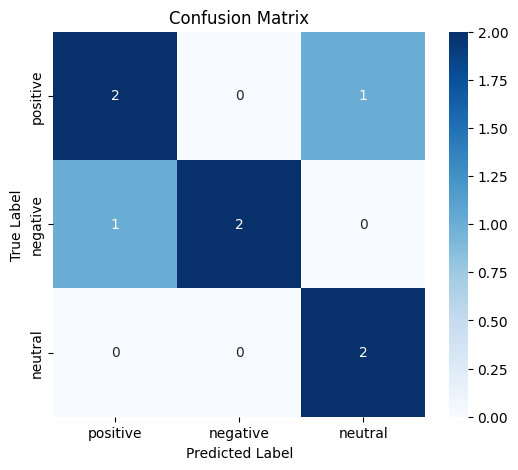

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
true_labels = ['positive', 'negative', 'neutral', 'positive', 'negative', 'neutral', 'positive', 'negative']
predicted_labels = ['positive', 'negative', 'neutral', 'neutral', 'negative', 'neutral', 'positive', 'positive']

# 1. Print Classification Report
print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, digits=2))

# 2. Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# 3. Confusion Matrix
labels = ['positive', 'negative', 'neutral']
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

# 4. Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

 ### Performance Comparison Chart
This cell visualizes the performance difference between the "Simple Prompt" and "Enhanced Prompt" strategies tested earlier. The bar chart makes it easy to compare metrics like Accuracy, Precision, Recall, and F1-Score, highlighting the performance gap.

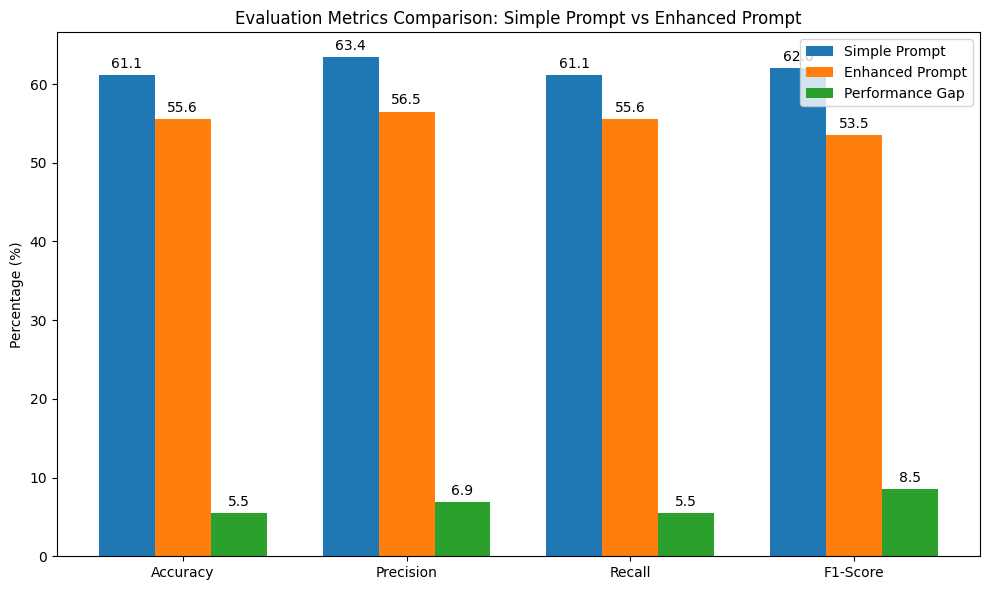

In [ ]:
#@title Performance Comparison Chart
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample data based on evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
simple_prompt_scores = [61.1, 63.4, 61.1, 62.0]
enhanced_prompt_scores = [55.6, 56.5, 55.6, 53.5]
performance_gap = [5.5, 6.9, 5.5, 8.5]

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, simple_prompt_scores, width, label='Simple Prompt')
rects2 = ax.bar(x, enhanced_prompt_scores, width, label='Enhanced Prompt')
rects3 = ax.bar(x + width, performance_gap, width, label='Performance Gap')

ax.set_ylabel('Percentage (%)')
ax.set_title('Evaluation Metrics Comparison: Simple Prompt vs Enhanced Prompt')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


🚀 Initializing YouTube Comments Sentiment Analysis...
🎥 Video: We Reacted To The Great Indian Stomach 🫡 Ft. @soulfulsouthvlogss
📺 Channel: Pranay Varma
👀 Views: 1533151 | 💬 Total Comments: 1184
🔄 Starting analysis of 50 comments...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Negative' -> Extracted: Negative


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DEBUG: LLM Response: 'Neutral' -> Extracted: Neutral



✅ Analysis completed in 19.84 seconds!
⚡ Average processing time per comment: 0.40s

🎨 Creating visualizations for 50 comments...


/tmp/ipython-input-13-1780366588.py:163: UserWarning: Glyph 129761 (\N{SALUTING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129761 (\N{SALUTING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


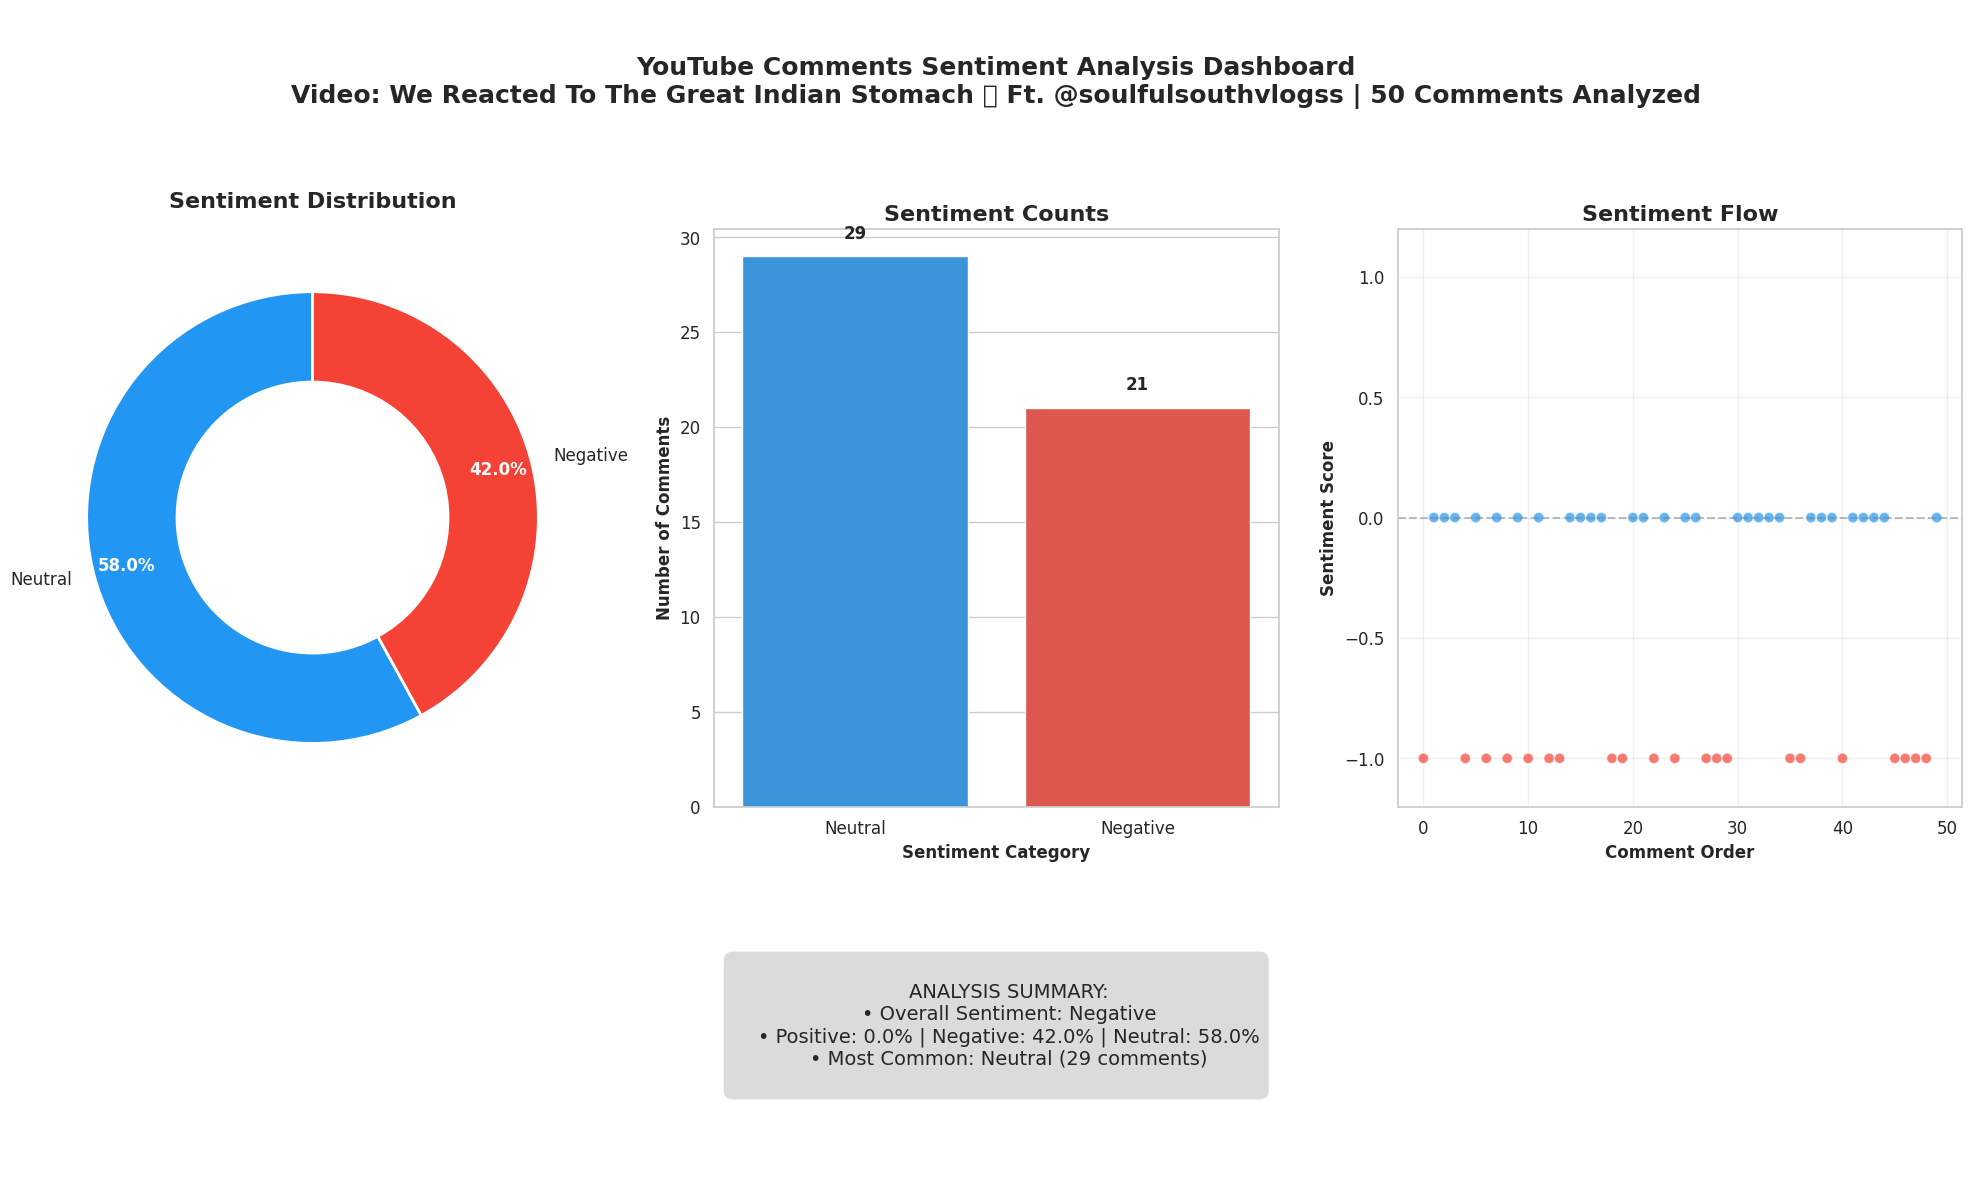

Results are stored in 'df_results' DataFrame for further analysis!
You can export to CSV using: df_results.to_csv('youtube_sentiment_analysis.csv', index=False)


In [ ]:
#@title 📊 Enhanced YouTube Comments Sentiment Dashboard - version 1
#@markdown ---
#@markdown ### Paste your YouTube video link below and set the number of comments to analyze.

# --- Import Libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from urllib.parse import urlparse, parse_qs
import time
import re
from IPython.display import display, HTML, clear_output
import textwrap
from datetime import datetime

# --- Configuration (Interactive in Colab) ---
YOUTUBE_VIDEO_URL = "https://youtu.be/_HJD17g-_l4?si=AL3y3Jw3I5Lm79ng" #@param {type:"string"}
MAX_COMMENTS_TO_ANALYZE = 50 #@param {type:"integer"}
SHOW_COMMENTS_DURING_PROCESSING = True #@param {type:"boolean"}
TRUNCATE_LONG_COMMENTS = True #@param {type:"boolean"}
MAX_COMMENT_DISPLAY_LENGTH = 150 #@param {type:"integer"}

# --- Enhanced Visualization Settings ---
plt.style.use('default')
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.1)

sentiment_colors = {
    "Positive": "#4CAF50",  # Green
    "Negative": "#F44336",  # Red
    "Neutral":  "#2196F3",   # Blue
    "Unknown":  "#9E9E9E",   # Gray
    "Error":    "#FFC107"    # Amber
}

# --- Helper Functions ---
def truncate_text(text, max_length=150):
    """Truncate text if it's too long for display"""
    if TRUNCATE_LONG_COMMENTS and len(text) > max_length:
        return text[:max_length] + "..."
    return text

def display_comment_analysis(comment_num, total_comments, comment_text, sentiment, processing_time=None):
    """Display each comment as it's being analyzed with better formatting"""

    # Truncate comment for display
    display_text = truncate_text(comment_text, MAX_COMMENT_DISPLAY_LENGTH)

    # Create color-coded HTML output
    sentiment_color = sentiment_colors.get(sentiment, "#9E9E9E")

    html_output = f"""
    <div style='border-left: 4px solid {sentiment_color};
                background: linear-gradient(90deg, {sentiment_color}15, transparent);
                padding: 12px; margin: 8px 0; border-radius: 0 8px 8px 0;
                font-family: "Segoe UI", Arial, sans-serif;'>
        <div style='display: flex; justify-content: space-between; align-items: center; margin-bottom: 8px;'>
            <strong style='color: {sentiment_color}; font-size: 14px;'>
                📝 Comment {comment_num}/{total_comments} | Sentiment: {sentiment}
            </strong>
            {f'<span style="color: #666; font-size: 12px;">⏱️ {processing_time:.2f}s</span>' if processing_time else ''}
        </div>
        <div style='background: rgba(255,255,255,0.8); padding: 10px; border-radius: 6px;
                    border: 1px solid #e0e0e0; font-size: 13px; line-height: 1.4;'>
            <em>"{display_text}"</em>
        </div>
    </div>
    """

    display(HTML(html_output))

def create_enhanced_visualizations(df_results, video_info=None):
    """Create enhanced visualizations with better styling"""

    sentiment_counts = df_results['Sentiment'].value_counts()

    # Create a larger figure with better layout
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, height_ratios=[0.5, 2, 1], width_ratios=[1, 1, 1])

    # Title section
    title_ax = fig.add_subplot(gs[0, :])
    title_ax.axis('off')
    title_text = f'YouTube Comments Sentiment Analysis Dashboard\n'
    if video_info:
        title_text += f'Video: {video_info.get("title", "Unknown")} | {len(df_results)} Comments Analyzed'
    else:
        title_text += f'{len(df_results)} Comments Analyzed'

    title_ax.text(0.5, 0.5, title_text, fontsize=18, fontweight='bold',
                  ha='center', va='center', transform=title_ax.transAxes)

    # Donut Chart
    ax1 = fig.add_subplot(gs[1, 0])
    wedges, texts, autotexts = ax1.pie(sentiment_counts, labels=sentiment_counts.index,
                                       autopct='%1.1f%%', startangle=90, pctdistance=0.85,
                                       colors=[sentiment_colors.get(x, "#BDBDBD") for x in sentiment_counts.index],
                                       wedgeprops=dict(width=0.4, edgecolor='white', linewidth=2))

    # Enhance pie chart text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)

    ax1.set_title('Sentiment Distribution', fontsize=16, fontweight='bold', pad=20)

    # Bar Chart
    ax2 = fig.add_subplot(gs[1, 1])
    bars = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax2,
                       hue=sentiment_counts.index,
                       palette=[sentiment_colors.get(x, "#BDBDBD") for x in sentiment_counts.index],
                       order=sentiment_counts.index, legend=False)

    ax2.set_title('Sentiment Counts', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Number of Comments', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Sentiment Category', fontsize=12, fontweight='bold')

    # Add value labels on bars
    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        ax2.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 10), textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Sentiment Timeline (if timestamps available)
    ax3 = fig.add_subplot(gs[1, 2])
    sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1, 'Unknown': 0.5, 'Error': 0}
    df_results['sentiment_score'] = df_results['Sentiment'].map(sentiment_mapping)

    ax3.scatter(range(len(df_results)), df_results['sentiment_score'],
               c=[sentiment_colors.get(s, "#9E9E9E") for s in df_results['Sentiment']],
               alpha=0.7, s=60, edgecolors='white', linewidth=1)
    ax3.set_title('Sentiment Flow', fontsize=16, fontweight='bold')
    ax3.set_xlabel('Comment Order', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Sentiment Score', fontsize=12, fontweight='bold')
    ax3.set_ylim(-1.2, 1.2)
    ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax3.grid(True, alpha=0.3)

    # Statistics summary
    stats_ax = fig.add_subplot(gs[2, :])
    stats_ax.axis('off')

    total_comments = len(df_results)
    positive_pct = (sentiment_counts.get('Positive', 0) / total_comments) * 100
    negative_pct = (sentiment_counts.get('Negative', 0) / total_comments) * 100
    neutral_pct = (sentiment_counts.get('Neutral', 0) / total_comments) * 100

    stats_text = f"""
    ANALYSIS SUMMARY:
    • Overall Sentiment: {"Positive" if positive_pct > negative_pct else "Negative" if negative_pct > positive_pct else "Neutral"}
    • Positive: {positive_pct:.1f}% | Negative: {negative_pct:.1f}% | Neutral: {neutral_pct:.1f}%
    • Most Common: {sentiment_counts.index[0]} ({sentiment_counts.iloc[0]} comments)
    """

    stats_ax.text(0.5, 0.5, stats_text, fontsize=14, ha='center', va='center',
                  transform=stats_ax.transAxes,
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

    plt.tight_layout()
    plt.show()

def get_video_info(youtube, video_id):
    """Fetch video information"""
    try:
        request = youtube.videos().list(part="snippet,statistics", id=video_id)
        response = request.execute()
        if response["items"]:
            video_data = response["items"][0]
            return {
                "title": video_data["snippet"]["title"],
                "channel": video_data["snippet"]["channelTitle"],
                "view_count": video_data["statistics"].get("viewCount", "N/A"),
                "like_count": video_data["statistics"].get("likeCount", "N/A"),
                "comment_count": video_data["statistics"].get("commentCount", "N/A")
            }
    except Exception as e:
        print(f"⚠️ Could not fetch video info: {e}")
    return None

# --- Check for Prerequisite Functions ---
if 'get_youtube_api_key' not in globals() or 'extract_video_id' not in globals() or 'classify_sentiment_llama3_telugu_youtube' not in globals():
    print("❌ Error: Prerequisite functions not found. Please run the preceding cells to define them.")
else:
    # --- Main Logic: Fetch, Analyze, and Visualize ---
    print("🚀 Initializing YouTube Comments Sentiment Analysis...")
    print("=" * 60)

    api_key = get_youtube_api_key()
    video_id = extract_video_id(YOUTUBE_VIDEO_URL)
    comments_list = []

    if api_key and video_id:
        try:
            youtube = build('youtube', 'v3', developerKey=api_key)

            # Get video information
            video_info = get_video_info(youtube, video_id)
            if video_info:
                print(f"🎥 Video: {video_info['title']}")
                print(f"📺 Channel: {video_info['channel']}")
                print(f"👀 Views: {video_info['view_count']} | 💬 Total Comments: {video_info['comment_count']}")
                print("=" * 60)

            print(f"🔄 Starting analysis of {MAX_COMMENTS_TO_ANALYZE} comments...")

            next_page_token = None
            comments_fetched = 0
            start_time = time.time()

            while comments_fetched < MAX_COMMENTS_TO_ANALYZE:
                request = youtube.commentThreads().list(
                    part="snippet",
                    videoId=video_id,
                    maxResults=min(100, MAX_COMMENTS_TO_ANALYZE - comments_fetched),
                    textFormat="plainText",
                    pageToken=next_page_token
                )
                response = request.execute()

                for item in response.get("items", []):
                    if comments_fetched >= MAX_COMMENTS_TO_ANALYZE:
                        break

                    comment_snippet = item["snippet"]["topLevelComment"]["snippet"]
                    comment_cleaned = re.sub(r'\s+', ' ', comment_snippet["textDisplay"]).strip()
                    author_name = comment_snippet.get("authorDisplayName", "Unknown")
                    published_at = comment_snippet.get("publishedAt", "")

                    if not comment_cleaned:
                        continue

                    # Time the sentiment analysis
                    analysis_start = time.time()
                    sentiment = classify_sentiment_llama3_telugu_youtube(comment_cleaned)
                    analysis_time = time.time() - analysis_start

                    # Display comment during processing
                    if SHOW_COMMENTS_DURING_PROCESSING:
                        display_comment_analysis(
                            comments_fetched + 1,
                            MAX_COMMENTS_TO_ANALYZE,
                            comment_cleaned,
                            sentiment,
                            analysis_time
                        )

                    comments_list.append({
                        "Comment": comment_cleaned,
                        "Sentiment": sentiment,
                        "Author": author_name,
                        "Published": published_at,
                        "Analysis_Time": analysis_time
                    })
                    comments_fetched += 1

                next_page_token = response.get("nextPageToken")
                if not next_page_token or comments_fetched >= MAX_COMMENTS_TO_ANALYZE:
                    break
                time.sleep(0.3)  # Reduced sleep time for faster processing

            total_time = time.time() - start_time
            print(f"\n✅ Analysis completed in {total_time:.2f} seconds!")
            print(f"⚡ Average processing time per comment: {total_time/len(comments_list):.2f}s")

        except HttpError as e:
            print(f"\n❌ An HTTP error occurred: {e.reason}")
            print("💡 Check your API key and video URL.")
        except Exception as e:
            print(f"\n❌ An unexpected error occurred: {e}")

    # --- Process and Visualize Results ---
    if comments_list:
        print(f"\n🎨 Creating visualizations for {len(comments_list)} comments...")
        df_results = pd.DataFrame(comments_list)

        # Create enhanced visualizations
        create_enhanced_visualizations(df_results, video_info)

        # Display detailed comment examples with better formatting
        display(HTML('<div style="margin-top: 30px;"><h2 style="color: #333; border-bottom: 3px solid #4CAF50; padding-bottom: 10px;">Comment Examples by Sentiment</h2></div>'))

        for sentiment_type in ['Positive', 'Negative', 'Neutral', 'Unknown', 'Error']:
            examples = df_results[df_results['Sentiment'] == sentiment_type].head(5)  # Show more examples
            if not examples.empty:
                sentiment_color = sentiment_colors.get(sentiment_type, "#9E9E9E")

                html = f"""
                <div style='border: 2px solid {sentiment_color};
                           border-radius: 12px;
                           background: linear-gradient(135deg, {sentiment_color}10, {sentiment_color}05);
                           padding: 20px;
                           margin: 20px 0;
                           font-family: "Segoe UI", Arial, sans-serif;
                           box-shadow: 0 4px 6px rgba(0,0,0,0.1);'>
                  <h3 style='color: {sentiment_color};
                             margin-top: 0;
                             margin-bottom: 15px;
                             display: flex;
                             align-items: center;
                             font-size: 18px;'>
                    <span style='margin-right: 10px; font-size: 24px;'>
                      {'😊' if sentiment_type == 'Positive' else '😔' if sentiment_type == 'Negative' else '😐' if sentiment_type == 'Neutral' else '❓' if sentiment_type == 'Unknown' else '⚠️'}
                    </span>
                    {sentiment_type} Comments ({len(examples)} shown)
                  </h3>
                  <div style='space-y: 10px;'>
                """

                for idx, (_, row) in enumerate(examples.iterrows(), 1):
                    comment_text = truncate_text(row['Comment'], 200)
                    analysis_time = row.get('Analysis_Time', 0)

                    html += f"""
                    <div style='background: rgba(255,255,255,0.7);
                               padding: 15px;
                               border-radius: 8px;
                               margin-bottom: 12px;
                               border-left: 4px solid {sentiment_color};'>
                        <div style='font-size: 14px; color: #666; margin-bottom: 8px; display: flex; justify-content: space-between;'>
                            <span><strong>Example {idx}</strong> • By: {row.get('Author', 'Unknown')}</span>
                            <span>⏱️ {analysis_time:.2f}s</span>
                        </div>
                        <div style='font-size: 15px; line-height: 1.5; color: #333;'>
                            <em>"{comment_text}"</em>
                        </div>
                    </div>
                    """

                html += "</div></div>"
                display(HTML(html))

        # Final summary statistics
        sentiment_counts = df_results['Sentiment'].value_counts()
        avg_analysis_time = df_results['Analysis_Time'].mean()

        summary_html = f"""
        <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                    color: white;
                    padding: 25px;
                    border-radius: 15px;
                    margin: 30px 0;
                    text-align: center;
                    box-shadow: 0 8px 16px rgba(0,0,0,0.2);'>
            <h2 style='margin-top: 0; font-size: 24px;'>Analysis Complete!</h2>
            <div style='display: flex; justify-content: space-around; margin-top: 20px; flex-wrap: wrap;'>
                <div style='text-align: center; margin: 10px;'>
                    <div style='font-size: 28px; font-weight: bold;'>{len(df_results)}</div>
                    <div style='font-size: 14px; opacity: 0.9;'>Comments Analyzed</div>
                </div>
                <div style='text-align: center; margin: 10px;'>
                    <div style='font-size: 28px; font-weight: bold;'>{avg_analysis_time:.2f}s</div>
                    <div style='font-size: 14px; opacity: 0.9;'>Avg Analysis Time</div>
                </div>
                <div style='text-align: center; margin: 10px;'>
                    <div style='font-size: 28px; font-weight: bold;'>{sentiment_counts.index[0]}</div>
                    <div style='font-size: 14px; opacity: 0.9;'>Most Common Sentiment</div>
                </div>
            </div>
        </div>
        """
        display(HTML(summary_html))

        # Option to download results
        print("Results are stored in 'df_results' DataFrame for further analysis!")
        print("You can export to CSV using: df_results.to_csv('youtube_sentiment_analysis.csv', index=False)")

    else:
        display(HTML("""
        <div style='background: #ffebee;
                    border: 2px solid #f44336;
                    color: #c62828;
                    padding: 20px;
                    border-radius: 10px;
                    text-align: center;
                    margin: 20px 0;'>
            <h3>No comments were processed</h3>
            <p>Please check your video URL and API configuration.</p>
        </div>
        """))

## Interactive YouTube Sentiment Dashboard
This is the final, user-facing application. It uses ipywidgets to create an interactive dashboard with an attractive HTML/CSS introduction. Users can paste a YouTube URL, configure analysis options, and click "Start Analysis" to see comments being classified in real-time. Once complete, it displays comprehensive visualizations, including a donut chart, bar chart, and a results summary.

In [ ]:
#@title 🎬 Interactive YouTube Sentiment Analysis Dashboard - final version with frontend
#@markdown ---
#@markdown ### Welcome to the YouTube Comments Sentiment Analyzer!
#@markdown This tool analyzes the sentiment of YouTube video comments using advanced AI.

# --- Import Libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from urllib.parse import urlparse, parse_qs
import time
import re
from IPython.display import display, HTML, clear_output
import textwrap
from datetime import datetime
import ipywidgets as widgets
from IPython.display import Javascript
import threading
import queue
import json

# --- Global Variables ---
current_analysis = None
analysis_running = False

# --- Enhanced Visualization Settings ---
plt.style.use('default')
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.1)

sentiment_colors = {
    "Positive": "#4CAF50",  # Green
    "Negative": "#F44336",  # Red
    "Neutral":  "#2196F3",   # Blue
    "Unknown":  "#9E9E9E",   # Gray
    "Error":    "#FFC107"    # Amber
}

# --- Helper Functions ---
def show_intro_page():
    """Display an attractive intro page for the dashboard"""
    intro_html = """
    <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                padding: 40px;
                border-radius: 20px;
                margin: 20px 0;
                text-align: center;
                box-shadow: 0 10px 30px rgba(0,0,0,0.3);
                font-family: "Segoe UI", Arial, sans-serif;'>

        <h1 style='font-size: 36px; margin-bottom: 10px; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);'>
            YouTube Sentiment Analyzer
        </h1>

        <p style='font-size: 18px; margin-bottom: 30px; opacity: 0.9;'>
            Discover what people really think about any YouTube video
        </p>

        <div style='background: rgba(255,255,255,0.1);
                    border-radius: 15px;
                    padding: 30px;
                    margin: 20px 0;
                    backdrop-filter: blur(10px);'>

            <h2 style='color: #FFE082; margin-bottom: 20px; font-size: 24px;'>Features</h2>

            <div style='display: grid;
                        grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
                        gap: 20px;
                        margin: 20px 0;'>

                <div style='background: rgba(255,255,255,0.1);
                           padding: 20px;
                           border-radius: 12px;
                           border-left: 4px solid #4CAF50;'>
                    <h3 style='color: #C8E6C9; margin-bottom: 10px;'>Real-time Analysis</h3>
                    <p style='font-size: 14px; line-height: 1.5; opacity: 0.9;'>
                        Watch comments being analyzed live with instant sentiment classification
                    </p>
                </div>

                <div style='background: rgba(255,255,255,0.1);
                           padding: 20px;
                           border-radius: 12px;
                           border-left: 4px solid #2196F3;'>
                    <h3 style='color: #BBDEFB; margin-bottom: 10px;'>Interactive Visualizations</h3>
                    <p style='font-size: 14px; line-height: 1.5; opacity: 0.9;'>
                        Beautiful charts, graphs, and sentiment flow analysis
                    </p>
                </div>

                <div style='background: rgba(255,255,255,0.1);
                           padding: 20px;
                           border-radius: 12px;
                           border-left: 4px solid #FF9800;'>
                    <h3 style='color: #FFE0B2; margin-bottom: 10px;'>Detailed Insights</h3>
                    <p style='font-size: 14px; line-height: 1.5; opacity: 0.9;'>
                        Comprehensive breakdown with examples and statistics
                    </p>
                </div>
            </div>
        </div>

        <div style='background: rgba(255,255,255,0.1);
                    border-radius: 15px;
                    padding: 25px;
                    margin: 20px 0;'>
            <h2 style='color: #FFE082; margin-bottom: 15px;'>How to Use</h2>
            <div style='text-align: left; max-width: 600px; margin: 0 auto;'>
                <p style='margin: 10px 0; padding-left: 20px; position: relative;'>
                    <span style='position: absolute; left: 0; color: #4CAF50; font-weight: bold;'>1.</span>
                    Enter a YouTube video URL in the input field below
                </p>
                <p style='margin: 10px 0; padding-left: 20px; position: relative;'>
                    <span style='position: absolute; left: 0; color: #2196F3; font-weight: bold;'>2.</span>
                    Set the number of comments you want to analyze
                </p>
                <p style='margin: 10px 0; padding-left: 20px; position: relative;'>
                    <span style='position: absolute; left: 0; color: #FF9800; font-weight: bold;'>3.</span>
                    Click "Start Analysis" and watch the magic happen!
                </p>
            </div>
        </div>

        <div style='margin-top: 30px; font-size: 14px; opacity: 0.8;'>
            <p>Powered by advanced AI sentiment analysis • Built for Google Colab</p>
        </div>
    </div>
    """

    display(HTML(intro_html))

def create_input_interface():
    """Create interactive input interface with widgets"""

    # Style for widgets
    style = {'description_width': '150px'}
    layout = widgets.Layout(width='400px')

    # Create widgets
    url_input = widgets.Text(
        value='https://www.youtube.com/watch?v=Jd4cASkBAp0', # Example Telugu video
        placeholder='Paste YouTube video URL here...',
        description='Video URL:',
        style=style,
        layout=widgets.Layout(width='600px')
    )

    max_comments = widgets.IntSlider(
        value=50,
        min=10,
        max=500,
        step=10,
        description='Max Comments:',
        style=style,
        layout=layout
    )

    show_processing = widgets.Checkbox(
        value=True,
        description='Show comments during processing',
        style=style,
        layout=layout
    )

    truncate_comments = widgets.Checkbox(
        value=True,
        description='Truncate long comments',
        style=style,
        layout=layout
    )

    max_length = widgets.IntSlider(
        value=150,
        min=50,
        max=300,
        step=25,
        description='Max Length:',
        style=style,
        layout=layout
    )

    # Create buttons
    analyze_button = widgets.Button(
        description='Start Analysis',
        button_style='success',
        layout=widgets.Layout(width='200px', height='40px'),
        icon='play'
    )

    stop_button = widgets.Button(
        description='Stop Analysis',
        button_style='danger',
        layout=widgets.Layout(width='200px', height='40px'),
        icon='stop'
    )

    clear_button = widgets.Button(
        description='Clear Results',
        button_style='info',
        layout=widgets.Layout(width='200px', height='40px'),
        icon='refresh'
    )

    # Output widget for results
    output = widgets.Output()

    # Button event handlers
    def start_analysis(b):
        global analysis_running
        if analysis_running:
            with output:
                print("Analysis already running! Please wait or stop the current analysis.")
            return

        url = url_input.value.strip()
        if not url:
            with output:
                display(HTML("""
                <div style='background: #ffebee;
                            border: 2px solid #f44336;
                            color: #c62828;
                            padding: 15px;
                            border-radius: 8px;
                            margin: 10px 0;'>
                    <strong>Please enter a YouTube video URL!</strong>
                </div>
                """))
            return

        # Clear previous output
        output.clear_output()

        # Start analysis
        with output:
            run_sentiment_analysis(
                url,
                max_comments.value,
                show_processing.value,
                truncate_comments.value,
                max_length.value
            )

    def stop_analysis(b):
        global analysis_running
        analysis_running = False
        with output:
            display(HTML("""
            <div style='background: #fff3e0;
                        border: 2px solid #ff9800;
                        color: #e65100;
                        padding: 15px;
                        border-radius: 8px;
                        margin: 10px 0;'>
                <strong>Analysis stopped by user! No further comments will be processed.</strong>
            </div>
            """))

    def clear_results(b):
        output.clear_output()
        global current_analysis, analysis_running
        current_analysis = None
        analysis_running = False

    # Bind button events
    analyze_button.on_click(start_analysis)
    stop_button.on_click(stop_analysis)
    clear_button.on_click(clear_results)

    # Create interface layout
    interface_html = """
    <div style='background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
                padding: 30px;
                border-radius: 15px;
                margin: 20px 0;
                border: 1px solid #ddd;
                box-shadow: 0 5px 15px rgba(0,0,0,0.1);'>
        <h2 style='color: #333; margin-bottom: 20px; text-align: center;'>
            Configuration Panel
        </h2>
    </div>
    """

    display(HTML(interface_html))

    # Display widgets
    display(widgets.VBox([
        url_input,
        widgets.HBox([max_comments, show_processing]),
        widgets.HBox([truncate_comments, max_length]),
        widgets.HBox([analyze_button, stop_button, clear_button]),
        output
    ]))

def truncate_text(text, max_length=150):
    """Truncate text if it's too long for display"""
    if len(text) > max_length:
        return textwrap.shorten(text, width=max_length, placeholder="...")
    return text

def display_comment_analysis(comment_num, total_comments, comment_text, sentiment, processing_time=None):
    """Display each comment as it's being analyzed with better formatting"""

    # Truncate comment for display
    display_text = truncate_text(comment_text, 150)

    # Create color-coded HTML output
    sentiment_color = sentiment_colors.get(sentiment, "#9E9E9E")

    html_output = f"""
    <div style='border-left: 4px solid {sentiment_color};
                background: linear-gradient(90deg, {sentiment_color}15, transparent);
                padding: 12px; margin: 8px 0; border-radius: 0 8px 8px 0;
                font-family: "Segoe UI", Arial, sans-serif;'>
        <div style='display: flex; justify-content: space-between; align-items: center; margin-bottom: 8px;'>
            <strong style='color: {sentiment_color}; font-size: 14px;'>
                Comment {comment_num}/{total_comments} | Sentiment: {sentiment}
            </strong>
            {f'<span style="color: #666; font-size: 12px;">Time: {processing_time:.2f}s</span>' if processing_time else ''}
        </div>
        <div style='background: rgba(255,255,255,0.8); padding: 10px; border-radius: 6px;
                    border: 1px solid #e0e0e0; font-size: 13px; line-height: 1.4;'>
            <em>"{display_text}"</em>
        </div>
    </div>
    """

    display(HTML(html_output))

def create_enhanced_visualizations(df_results, video_info=None):
    """Create enhanced visualizations with better styling"""

    sentiment_counts = df_results['Sentiment'].value_counts()

    # Create a larger figure with better layout
    fig = plt.figure(figsize=(20, 12), constrained_layout=True)
    gs = fig.add_gridspec(3, 2, height_ratios=[0.5, 2, 1])

    # Title section
    title_ax = fig.add_subplot(gs[0, :])
    title_ax.axis('off')
    title_text = f'YouTube Comments Sentiment Analysis\n'
    if video_info:
        title_text += f'Video: {truncate_text(video_info.get("title", "Unknown"), 80)} | {len(df_results)} Comments Analyzed'
    else:
        title_text += f'{len(df_results)} Comments Analyzed'

    title_ax.text(0.5, 0.5, title_text, fontsize=22, fontweight='bold',
                  ha='center', va='center', transform=title_ax.transAxes)

    # Donut Chart
    ax1 = fig.add_subplot(gs[1, 0])
    wedges, texts, autotexts = ax1.pie(sentiment_counts,
                                       autopct='%1.1f%%', startangle=90, pctdistance=0.85,
                                       colors=[sentiment_colors.get(x, "#BDBDBD") for x in sentiment_counts.index],
                                       wedgeprops=dict(width=0.4, edgecolor='white', linewidth=2))
    ax1.legend(wedges, sentiment_counts.index, title="Sentiments", loc="center left", bbox_to_anchor=(0.95, 0, 0.5, 1))
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
    ax1.set_title('Sentiment Distribution', fontsize=16, fontweight='bold', pad=20)

    # Bar Chart
    ax2 = fig.add_subplot(gs[1, 1])
    bars = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax2,
                       hue=sentiment_counts.index,
                       palette=[sentiment_colors.get(x, "#BDBDBD") for x in sentiment_counts.index],
                       order=sentiment_counts.index, legend=False)
    ax2.set_title('Sentiment Counts', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Number of Comments', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Sentiment Category', fontsize=12, fontweight='bold')
    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        ax2.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 10), textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Statistics summary
    stats_ax = fig.add_subplot(gs[2, :])
    stats_ax.axis('off')
    total_comments = len(df_results)
    positive_pct = (sentiment_counts.get('Positive', 0) / total_comments) * 100
    negative_pct = (sentiment_counts.get('Negative', 0) / total_comments) * 100
    neutral_pct = (sentiment_counts.get('Neutral', 0) / total_comments) * 100

    stats_text = f"""
    ANALYSIS SUMMARY:
    • Overall Sentiment: {"Positive" if positive_pct > negative_pct else "Negative" if negative_pct > positive_pct else "Neutral"}
    • Positive: {positive_pct:.1f}%  |  Negative: {negative_pct:.1f}%  |  Neutral: {neutral_pct:.1f}%
    • Most Common: {sentiment_counts.index[0]} ({sentiment_counts.iloc[0]} comments)
    """
    stats_ax.text(0.5, 0.5, stats_text, fontsize=14, ha='center', va='center',
                  transform=stats_ax.transAxes,
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="#e8eaf6", alpha=0.8))

    plt.show()

def get_video_info(youtube, video_id):
    """Fetch video information"""
    try:
        request = youtube.videos().list(part="snippet,statistics", id=video_id)
        response = request.execute()
        if response["items"]:
            video_data = response["items"][0]
            return {
                "title": video_data["snippet"]["title"],
                "channel": video_data["snippet"]["channelTitle"],
                "view_count": f'{int(video_data["statistics"].get("viewCount", 0)):,}',
                "like_count": f'{int(video_data["statistics"].get("likeCount", 0)):,}',
                "comment_count": f'{int(video_data["statistics"].get("commentCount", 0)):,}'
            }
    except Exception as e:
        print(f"Could not fetch video info: {e}")
    return None

def run_sentiment_analysis(video_url, max_comments, show_processing, truncate_long, max_length):
    """Main function to run sentiment analysis"""
    global analysis_running, current_analysis

    if not all(f in globals() for f in ['get_youtube_api_key', 'extract_video_id', 'classify_sentiment_llama3_telugu_youtube']):
        display(HTML("<div style='background: #ffebee; border: 2px solid #f44336; color: #c62828; padding: 20px; border-radius: 10px; margin: 20px 0;'><h3>Error: Prerequisite functions not found</h3><p>Please run the preceding cells to define the required functions.</p></div>"))
        return

    analysis_running = True
    comments_list = []

    display(HTML("<div style='background: linear-gradient(135deg, #4CAF50 0%, #45a049 100%); color: white; padding: 20px; border-radius: 15px; margin: 20px 0; text-align: center;'><h2>🚀 Starting Analysis...</h2><p style='margin: 10px 0 0 0; opacity: 0.9;'>Please wait while we analyze your video</p></div>"))

    try:
        api_key = get_youtube_api_key()
        video_id = extract_video_id(video_url)

        if not api_key or not video_id:
            display(HTML("<div style='background: #ffebee; border: 2px solid #f44336; color: #c62828; padding: 20px; border-radius: 10px; margin: 20px 0;'><h3>Configuration Error</h3><p>Please check your API key and video URL.</p></div>"))
            analysis_running = False
            return

        youtube = build('youtube', 'v3', developerKey=api_key)
        video_info = get_video_info(youtube, video_id)
        if video_info:
            info_html = f"""<div style='background: #f8f9fa; border: 1px solid #dee2e6; padding: 20px; border-radius: 10px; margin: 20px 0;'>
                <h3 style='color: #495057; margin-top: 0;'>Video Information</h3>
                <p><strong>Title:</strong> {video_info['title']}</p>
                <p><strong>Channel:</strong> {video_info['channel']}</p>
                <p><strong>Views:</strong> {video_info['view_count']} | <strong>Comments:</strong> {video_info['comment_count']}</p>
            </div>"""
            display(HTML(info_html))

        print(f"Analyzing up to {max_comments} comments...\n" + "=" * 60)

        next_page_token = None
        comments_fetched = 0
        start_time = time.time()

        while comments_fetched < max_comments and analysis_running:
            request = youtube.commentThreads().list(part="snippet", videoId=video_id, maxResults=min(100, max_comments - comments_fetched), textFormat="plainText", pageToken=next_page_token)
            response = request.execute()

            for item in response.get("items", []):
                if comments_fetched >= max_comments or not analysis_running: break
                comment_snippet = item["snippet"]["topLevelComment"]["snippet"]
                comment_cleaned = re.sub(r'\s+', ' ', comment_snippet["textDisplay"]).strip()
                if not comment_cleaned: continue

                analysis_start = time.time()
                sentiment = classify_sentiment_llama3_telugu_youtube(comment_cleaned)
                analysis_time = time.time() - analysis_start

                if show_processing:
                    display_comment_analysis(comments_fetched + 1, max_comments, comment_cleaned, sentiment, analysis_time)

                comments_list.append({"Comment": comment_cleaned, "Sentiment": sentiment, "Author": comment_snippet.get("authorDisplayName", "Unknown"), "Analysis_Time": analysis_time})
                comments_fetched += 1

            next_page_token = response.get("nextPageToken")
            if not next_page_token: break
            time.sleep(0.3)

        if not analysis_running:
            print("\nAnalysis was stopped by user.")
            analysis_running = False
            return

        total_time = time.time() - start_time
        print(f"\n✅ Analysis completed in {total_time:.2f} seconds!")

        if comments_list:
            print(f"Average processing time per comment: {total_time/len(comments_list):.2f}s")
            df_results = pd.DataFrame(comments_list)
            current_analysis = df_results
            create_enhanced_visualizations(df_results, video_info)
            display(HTML('<div style="margin-top: 30px;"><h2 style="color: #333; border-bottom: 3px solid #4CAF50; padding-bottom: 10px;">Comment Examples by Sentiment</h2></div>'))
            for sentiment_type in ['Positive', 'Negative', 'Neutral', 'Unknown', 'Error']:
                examples = df_results[df_results['Sentiment'] == sentiment_type].head(5)
                if not examples.empty:
                    sentiment_color = sentiment_colors.get(sentiment_type, "#9E9E9E")
                    html = f"""<div style='border: 2px solid {sentiment_color}; border-radius: 12px; background: linear-gradient(135deg, {sentiment_color}10, {sentiment_color}05); padding: 20px; margin: 20px 0; font-family: "Segoe UI", Arial, sans-serif; box-shadow: 0 4px 6px rgba(0,0,0,0.1);'><h3 style='color: {sentiment_color}; margin-top: 0; margin-bottom: 15px; font-size: 18px;'>{sentiment_type} Comments ({len(examples)} shown)</h3><div>"""
                    for idx, (_, row) in enumerate(examples.iterrows(), 1):
                        comment_text = truncate_text(row['Comment'], 200) if truncate_long else row['Comment']
                        html += f"""<div style='background: rgba(255,255,255,0.7); padding: 15px; border-radius: 8px; margin-bottom: 12px; border-left: 4px solid {sentiment_color};'><div style='font-size: 14px; color: #666; margin-bottom: 8px; display: flex; justify-content: space-between;'><span><strong>Example {idx}</strong> • By: {row.get('Author', 'Unknown')}</span><span>Time: {row.get('Analysis_Time', 0):.2f}s</span></div><div style='font-size: 15px; line-height: 1.5; color: #333;'><em>"{comment_text}"</em></div></div>"""
                    html += "</div></div>"
                    display(HTML(html))

            summary_html = f"""<div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 25px; border-radius: 15px; margin: 30px 0; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.2);'><h2 style='margin-top: 0; font-size: 24px;'>Analysis Complete!</h2><div style='display: flex; justify-content: space-around; margin-top: 20px; flex-wrap: wrap;'><div style='text-align: center; margin: 10px;'><div style='font-size: 28px; font-weight: bold;'>{len(df_results)}</div><div style='font-size: 14px; opacity: 0.9;'>Comments Analyzed</div></div><div style='text-align: center; margin: 10px;'><div style='font-size: 28px; font-weight: bold;'>{df_results['Analysis_Time'].mean():.2f}s</div><div style='font-size: 14px; opacity: 0.9;'>Avg Analysis Time</div></div><div style='text-align: center; margin: 10px;'><div style='font-size: 28px; font-weight: bold;'>{df_results['Sentiment'].value_counts().index[0]}</div><div style='font-size: 14px; opacity: 0.9;'>Most Common Sentiment</div></div></div></div>"""
            display(HTML(summary_html))

    except HttpError as e:
        error_content = e.content.decode("utf-8")
        try:
            error_json = json.loads(error_content)
            error_message = error_json.get("error", {}).get("message", "No detailed message available.")
        except json.JSONDecodeError:
            error_message = error_content

        error_html = f"""
        <div style='background: #ffebee; border: 2px solid #f44336; color: #c62828; padding: 20px; border-radius: 10px; margin: 20px 0; font-family: "Segoe UI", Arial, sans-serif;'>
            <h3 style='margin-top:0;'>YouTube API Error ({e.resp.status})</h3>
            <p><strong>Reason:</strong> {e.reason}</p>
            <p>This usually means one of the following:</p>
            <ul>
                <li>The YouTube Data API v3 is not enabled for your project.</li>
                <li>Your API key is invalid or has restrictions.</li>
                <li>You have exceeded your daily API usage quota.</li>
            </ul>
            <p><strong>Raw Error from Google:</strong></p>
            <pre style='background: #f5f5f5; padding: 10px; border-radius: 5px; white-space: pre-wrap; word-wrap: break-word;'>{error_message}</pre>
        </div>
        """
        display(HTML(error_html))

    except Exception as e:
        error_html = f"""
        <div style='background: #ffebee; border: 2px solid #f44336; color: #c62828; padding: 20px; border-radius: 10px; margin: 20px 0;'>
            <h3 style='margin-top:0;'>An Unexpected Error Occurred</h3>
            <pre style='background: #f5f5f5; padding: 10px; border-radius: 5px; white-space: pre-wrap;'>{str(e)}</pre>
        </div>
        """
        display(HTML(error_html))

    finally:
        analysis_running = False

# --- Show the Interface ---
show_intro_page()
create_input_interface()